## *** RESTORE FROM BACKUP**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp /content/drive/MyDrive/ECE-653/best_traffic_sign_model.pth .

In [3]:
!cp /content/drive/MyDrive/ECE-653/Dataset.zip . && unzip Dataset.zip && rm Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/train/00007_00010_00023_png.rf.7835cbcfa6babb68c444a538b0062f17.jpg  
  inflating: Dataset/train/000010_jpg.rf.280eb2d57ed2f197721d34f6ca6c533e.jpg  
  inflating: Dataset/train/00000_00002_00010_png.rf.d57c8945142f6d675990162cdd0dec93.jpg  
  inflating: Dataset/train/000071_jpg.rf.8ebafdeafe82ad824de0313dfde2c888.jpg  
  inflating: Dataset/train/001466_jpg.rf.5f1e09ac149f516e67ac48f70c3b761d.jpg  
  inflating: Dataset/train/00007_00002_00010_png.rf.52a4637f1c61ee211104e9c6d1824d3b.jpg  
  inflating: Dataset/train/road426_png.rf.0cbcc9797ab58af5eefaeb13f28b0c30.jpg  
  inflating: Dataset/train/00000_00005_00002_png.rf.12521c166f3ca192f74ef5a18e5aa2cd.jpg  
  inflating: Dataset/train/001239_jpg.rf.26b4ca5e1f95a67cfe87a10160625899.jpg  
  inflating: Dataset/train/00008_00017_00023_png.rf.4e62fa0b1e9860ed7ef6fcb473637736.jpg  
  inflating: Dataset/train/road371_png.rf.a11017d6c00cd51171d171d53e204235.jpg  
  inflating:

## **Set locale to UTF-8**

In [4]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

## **Import Packages**

In [5]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import grad
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from PIL import Image
from IPython.display import display
from google.colab.patches import cv2_imshow
from tqdm import tqdm

import os
import time
import random

## **Set to use CUDA**

In [6]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## **Class mapping**

In [7]:

class_to_idx = {
  'Speed Limit 10': 0,
  'Speed Limit 20': 1,
  'Speed Limit 30': 2,
  'Speed Limit 40': 3,
  'Speed Limit 50': 4,
  'Speed Limit 60': 5,
  'Speed Limit 70': 6,
  'Speed Limit 80': 7,
  'Speed Limit 90': 8,
  'Speed Limit 100': 9,
  'Speed Limit 110': 10,
  'Speed Limit 120': 11,
  'Stop': 12
}

class_names = {
    0: 'Speed Limit 10',
    1: 'Speed Limit 20',
    2: 'Speed Limit 30',
    3: 'Speed Limit 40',
    4: 'Speed Limit 50',
    5: 'Speed Limit 60',
    6: 'Speed Limit 70',
    7: 'Speed Limit 80',
    8: 'Speed Limit 90',
    9: 'Speed Limit 100',
    10: 'Speed Limit 110',
    11: 'Speed Limit 120',
    12: 'Stop'
}

## **SET PARAMS**

In [8]:
IMAGE_SIZE = 64
NUM_CLASSES = 13

# IMAGE_SIZE = 32
# NUM_CLASSES = 13

## **Define Our Classifier Model**

In [9]:
class SimpleTrafficSignNet(nn.Module):
    def __init__(self, num_classes=13):
        super(SimpleTrafficSignNet, self).__init__()

        # Layer definitions
        self.conv1 = nn.Conv2d(3, IMAGE_SIZE, kernel_size=5, padding=2)
        self.dropout1 = nn.Dropout(0.1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(IMAGE_SIZE, IMAGE_SIZE*2, kernel_size=5, padding=2)
        self.dropout2 = nn.Dropout(0.2)

        self.conv3 = nn.Conv2d(IMAGE_SIZE*2, IMAGE_SIZE*4, kernel_size=5, padding=2)
        self.dropout3 = nn.Dropout(0.3)

        # This is the key part - we need separate pooling layers with specific sizes
        # to match the Keras model architecture exactly
        self.pool4 = nn.MaxPool2d(kernel_size=8, stride=8)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout4 = nn.Dropout(0.5)

        self.fc1 = nn.Linear(28672, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        # Conv1 path
        x1 = self.conv1(x)
        x1 = F.relu(x1)
        x1 = self.dropout1(x1)
        x1_pooled = self.pool(x1)

        # Conv2 path
        x2 = self.conv2(x1_pooled)
        x2 = F.relu(x2)
        x2 = self.dropout2(x2)
        x2_pooled = self.pool(x2)

        # Conv3 path
        x3 = self.conv3(x2_pooled)
        x3 = F.relu(x3)
        x3 = self.dropout3(x3)
        x3_pooled = self.pool(x3)

        # Multiscale pooling paths (matching Keras exactly)
        # Path 1: pool4 directly on conv1 output (after dropout)
        path1 = self.pool4(x1)

        # Path 2: pool5 on the output of pool2
        path2 = self.pool5(x2_pooled)

        # Path 3: already at the right size from pool3
        path3 = x3_pooled

        # Flatten and concatenate
        flat1 = torch.flatten(path1, 1)
        flat2 = torch.flatten(path2, 1)
        flat3 = torch.flatten(path3, 1)

        merged = torch.cat([flat1, flat2, flat3], dim=1)

        # Dense layers
        dense1 = self.fc1(merged)
        dense1 = F.relu(dense1)
        dense1 = self.dropout4(dense1)

        # Output layer (logits, no activation)
        output = self.fc2(dense1)         # num_classes

        return output

## **Implement Inference**

In [10]:
def infer(model, cv_image):
    # Set model to evaluation mode
    cv2_image_rgb = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(cv2_image_rgb)
    transform = transforms.ToTensor()

    image_tensor = transform(image)
    image_tensor = image_tensor.permute(1, 2, 0)

    image_tensor = image_tensor.to(device)
    model = model.to(device)

    return predict(model, image_tensor)

# This predict function will be also used by adversarial attacks!
def predict(model, x_in):
    device = next(model.parameters()).device
    model.eval()

    with torch.no_grad():
        # Get current image dimensions
        h, w, c = x_in.shape

        # Convert numpy to tensor and add batch dimension
        x_tensor = torch.tensor(x_in, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

        if torch.any(x_tensor > 1.0):
            x_tensor = x_tensor / 255.0

        # Resize to model input size if needed
        if h != IMAGE_SIZE or w != IMAGE_SIZE:
            x_tensor = F.interpolate(x_tensor, size=(IMAGE_SIZE, IMAGE_SIZE), mode='bilinear', align_corners=False)

        outputs = model(x_tensor)

        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        prediction = outputs.argmax(dim=1).cpu().numpy()[0]


    return prediction, probabilities.squeeze().cpu().numpy()

def predict_class_only(model, x_in):
    prediction, _ = predict(model, x_in)
    return prediction

# Function to display prediction results
def display_prediction(predicted_class, probabilities):
    """
    Display the prediction results

    Args:
        predicted_class: Index of the predicted class
        probabilities: Probabilities for each class
    """
    print(f"Predicted class: {class_names[predicted_class]}")
    print(f"Confidence: {probabilities[predicted_class]*100:.2f}%")

    # Display top 3 predictions
    top3_indices = np.argsort(probabilities)[-3:][::-1]

    plt.figure(figsize=(10, 5))
    plt.barh([class_names[i] for i in top3_indices],
             [probabilities[i] for i in top3_indices])
    plt.xlabel('Probability')
    plt.title('Top 3 Predictions')
    plt.tight_layout()
    plt.show()

def perform_inference(model, cv_image, should_crop=False, display_pred=False):
    if should_crop:
      cv_image = crop_with_custom_model_cv2(cv_image)
      if cv_image is None:
          print("Nothing detected.")
          return None, None

    # Perform inference
    predicted_class, probabilities = infer(model, cv_image)

    if display_pred:
      display_prediction(predicted_class, probabilities)

    return predicted_class, probabilities

## **Implement Normalization(Transform) / Visualize Attack**

In [11]:
# Transform for input preprocessing
def get_transform():
    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # This is biliniear interpolation
        transforms.ToTensor()
    ])
    return transform

In [12]:
# Visualize the original and adversarial images
def visualize_attack(test, original_image, adv_image, target_class, src_class, dst_class):
    """
    Visualizes the original and adversarial images side by side.
    """
    # Move tensors to CPU for visualization
    original_image_cpu = original_image.cpu()
    adv_image_cpu = adv_image.cpu()

    orig_img = original_image_cpu.squeeze(0)
    adv_img = adv_image_cpu.squeeze(0)

    # Calculate perturbation
    perturbation = orig_img - adv_img

    if test:
      # Calculate L0, L2, and L∞ norms
      l0_norm = torch.sum(perturbation != 0).item() / perturbation.numel()
      l2_norm = torch.norm(perturbation).item()
      linf_norm = torch.max(torch.abs(perturbation)).item()

      # Calculate perturbation percentage
      total_pixels = perturbation.shape[1] * perturbation.shape[2]
      nonzero_pixels = torch.sum(torch.sum(torch.abs(perturbation), dim=0) > 0).item()
      pixel_percent = (nonzero_pixels / total_pixels) * 100

      print(f"Perturbation stats:")
      print(f"- L0 norm (sparsity): {l0_norm:.4f} ({pixel_percent:.2f}% of pixels modified)")
      print(f"- L2 norm (magnitude): {l2_norm:.4f}")
      print(f"- L∞ norm (max change): {linf_norm:.4f}")

      # Normalize perturbation for better visibility
      perturbation_display = (perturbation - perturbation.min()) / (perturbation.max() - perturbation.min() + 1e-8)

      # Create figure
      fig, axs = plt.subplots(1, 3, figsize=(18, 6))

      # Original image
      axs[0].imshow(orig_img.permute(1, 2, 0).clamp(0, 1).numpy())
      axs[0].set_title(f"Original:\nPredicted={class_names[src_class]}")
      axs[0].axis('off')

      # Adversarial image
      if target_class == None:
        axs[1].imshow(adv_img.permute(1, 2, 0).clamp(0, 1).numpy())
        axs[1].set_title(f"Adversarial:\nPredicted={class_names[dst_class]}")
        axs[1].axis('off')
      else:
        axs[1].imshow(adv_img.permute(1, 2, 0).clamp(0, 1).numpy())
        axs[1].set_title(f"Adversarial:\nPredicted={class_names[dst_class]}\nTarget={class_names[target_class]}")
        axs[1].axis('off')

      # Perturbation
      axs[2].imshow(perturbation_display.permute(1, 2, 0).numpy())
      axs[2].axis('off')

      plt.tight_layout()
      plt.show()

    # Return the adversarial image for saving
    return adv_img


## **Implement Attacks**

### Define Params

In [13]:
N_CHANNEL = 3
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, N_CHANNEL)
BATCH_SIZE = 32

### Define Common Functions for Attack

In [14]:
def gradient_input(model, x, y_target):
    """
    Calculate gradient of loss with respect to input, preserving original image size

    Parameters
    ----------
    model    : PyTorch model
    x        : numpy array, shape=(height, width, n_channel)
               Input image to compute gradient on
    y_target : numpy array, shape=(n_classes)
               Target label (one-hot encoded)

    Returns
    -------
    grad_input : numpy array, shape=(height, width, n_channel)
                Gradient of loss with respect to input at original size
    """
    device = next(model.parameters()).device

    # Get current image dimensions
    h, w, c = x.shape

    # Convert numpy to tensor and add batch dimension
    x_tensor = torch.tensor(x, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

    if torch.any(x_tensor) > 1.0:
       x_tensor = x_tensor / 255.0

    # Resize to model input size if needed (model expects IMAGE_SIZE x IMAGE_SIZE)
    if h != IMAGE_SIZE or w != IMAGE_SIZE:
        x_resized = F.interpolate(x_tensor, size=(IMAGE_SIZE, IMAGE_SIZE), mode='bilinear', align_corners=False)
    else:
        x_resized = x_tensor

    # Set requires_grad on the resized tensor
    x_resized.requires_grad = True

    # Convert one-hot y_target to class index
    target_idx = np.argmax(y_target)
    y_tensor = torch.tensor([target_idx], dtype=torch.long).to(device)

    # Forward pass
    model.eval()
    logits = model(x_resized)

    # Calculate loss
    loss = F.cross_entropy(logits, y_tensor)

    # Compute gradient
    model.zero_grad()
    loss.backward()

    # Get gradient with respect to input
    grad_input = x_resized.grad.data.cpu().numpy()[0]

    # Resize gradient back to original image size if needed
    if h != IMAGE_SIZE or w != IMAGE_SIZE:
        # Convert gradient channels from (C, H, W) to (H, W, C)
        grad_input_hwc = np.transpose(grad_input, (1, 2, 0))
        # Resize using cv2
        grad_input_resized = cv2.resize(grad_input_hwc, (w, h), interpolation=cv2.INTER_LINEAR)
        return grad_input_resized

    # Transpose to match expected shape (height, width, channels)
    return np.transpose(grad_input, (1, 2, 0))

class RandomTransform:
    """
    Random transformation for adversarial attack resilience
    """
    def __init__(self, seed=None, p=1.0, intensity=0.1):
        self.rng = np.random.RandomState(seed)
        self.p = p  # Probability of applying transformation
        self.intensity = intensity
        self.last_transform = None

    def transform(self, img):
        # Apply random transformation with probability p
        if self.rng.random() < self.p:
            # Decide which transformation to apply
            # For simplicity, just implementing a rotation/shift
            angle = self.rng.uniform(-30, 30) * self.intensity
            tx = self.rng.uniform(-10, 10) * self.intensity
            ty = self.rng.uniform(-10, 10) * self.intensity

            # Save transformation parameters
            self.last_transform = (angle, tx, ty)

            # Apply transformation (simplified)
            # In a real implementation, you'd use proper affine transforms
            # Here using a placeholder approach
            from scipy import ndimage
            transformed = ndimage.rotate(img, angle, reshape=False)
            transformed = ndimage.shift(transformed, (ty, tx, 0))
            return np.clip(transformed, 0, 1)

        self.last_transform = (0, 0, 0)  # No transformation
        return img

    def apply_transform(self, img, transform_params):
        angle, tx, ty = transform_params

        # Apply the specified transformation
        from scipy import ndimage
        transformed = ndimage.rotate(img, angle, reshape=False)
        transformed = ndimage.shift(transformed, (ty, tx, 0))
        return np.clip(transformed, 0, 1)

    def get_last_transform(self):
        return self.last_transform


class RandomEnhance:
    """
    Random enhancement for adversarial attack resilience
    """
    def __init__(self, seed=None, p=1.0, intensity=0.1):
        self.rng = np.random.RandomState(seed)
        self.p = p  # Probability of applying enhancement
        self.intensity = intensity
        self.last_factors = None

    def enhance(self, img):
        # Apply random enhancement with probability p
        if self.rng.random() < self.p:
            # Random brightness, contrast, and color adjustments
            brightness = 1.0 + self.rng.uniform(-0.2, 0.2) * self.intensity
            contrast = 1.0 + self.rng.uniform(-0.2, 0.2) * self.intensity
            color = 1.0 + self.rng.uniform(-0.2, 0.2) * self.intensity

            # Save enhancement parameters
            self.last_factors = (brightness, contrast, color)

            # Apply enhancements
            return self.enhance_factors(img, self.last_factors)

        self.last_factors = (1.0, 1.0, 1.0)  # No enhancement
        return img

    def enhance_factors(self, img, factors):
        brightness, contrast, color = factors

        # Apply brightness
        img_bright = img * brightness

        # Apply contrast
        img_mean = np.mean(img_bright, axis=(0, 1), keepdims=True)
        img_contrast = img_mean + (img_bright - img_mean) * contrast

        # Apply color (simplified)
        img_gray = np.mean(img_contrast, axis=2, keepdims=True)
        img_color = img_gray + (img_contrast - img_gray) * color

        return np.clip(img_color, 0, 1)

    def get_last_factors(self):
        return self.last_factors


### Define FG

In [15]:
def fg(model, x, y, mag_list, target=True, mask=None):
    """
    Fast Gradient attack for PyTorch models with support for different image sizes

    Parameters
    ----------
    model    : PyTorch Model
               Model to attack
    x        : list of np.array, each with shape (height, width, n_channel)
               Benign samples to attack
    y        : np.array, shape=(n_sample, NUM_LABELS)
               Target label for each sample
    mag_list : list of float
               List of perturbation magnitude to use in the attack
    target   : (optional) bool
               True, if targeted attack. False, otherwise.
    mask     : (optional) list of np.array or None
               Mask to restrict gradient update on valid pixels

    Return
    ------
    x_adv    : list of lists, where x_adv[mag_idx][img_idx] is a numpy array
               Adversarial examples for each magnitude and image
    """
    # Initialize output structure
    x_adv = [[None for _ in range(len(x))] for _ in range(len(mag_list))]
    start_time = time.time()

    for i, x_in in enumerate(x):
        # Retrieve gradient
        if target:
            grad_input_val = -1 * gradient_input(model, x_in, y[i])
        else:
            grad_input_val = gradient_input(model, x_in, y[i])

        # Apply mask if provided
        if mask is not None:
            mask_sample = mask[i]
            mask_rep = np.repeat(mask_sample[:, :, np.newaxis], x_in.shape[2], axis=2)
            grad_input_val *= mask_rep

        # Normalize gradient
        try:
            grad_input_val /= np.linalg.norm(grad_input_val)
        except ZeroDivisionError:
            raise

        # Generate adversarial examples for each magnitude
        for j, mag in enumerate(mag_list):
            x_adv_sample = x_in + grad_input_val * mag
            x_adv_sample = np.clip(x_adv_sample, 0, 1)
            x_adv[j][i] = x_adv_sample

        # Progress printing
        if (i % 1000 == 0) and (i > 0):
            elapsed_time = time.time() - start_time
            print(f"Finished {i} samples in {elapsed_time:.2f}s.")
            start_time = time.time()

    return x_adv

### Define Iterative

In [16]:
def iterative(model, x, y, norm="2", n_step=20, step_size=0.05, target=True, mask=None):
    """
    Iterative attack for PyTorch models with support for different image sizes

    Parameters
    ----------
    model     : PyTorch Model
                Model to attack
    x         : list of np.array, each with shape (height, width, n_channel)
                Benign samples to attack
    y         : np.array, shape=(n_sample, NUM_LABELS)
                Target label for each sample
    norm      : (optional) string
                "2" = L-2 norm (default)
                "inf" = L-infinity norm
    n_step    : (optional) int
                Number of iteration to take
    step_size : (optional) float
                Magnitude of perturbation in each iteration
    target    : (optional) bool
                True, if targeted attack. False, otherwise.
    mask      : (optional) list of np.array or None
                Mask to restrict gradient update on valid pixels

    Return
    ------
    x_adv     : list of np.array
                Adversarial examples
    """
    x_adv = [None for _ in range(len(x))]
    start_time = time.time()

    for i, x_in in enumerate(x):
        x_cur = np.copy(x_in)

        # Get mask with the same shape as gradient
        if mask is not None:
            mask_rep = np.repeat(mask[i][:, :, np.newaxis], x_in.shape[2], axis=2)

        # Start update in steps
        for _ in range(n_step):
            if target:
                grad_input_val = -1 * gradient_input(model, x_cur, y[i])
            else:
                grad_input_val = gradient_input(model, x_cur, y[i])

            if norm == "2":
                try:
                    grad_input_val /= np.linalg.norm(grad_input_val)
                except ZeroDivisionError:
                    raise
            elif norm == "inf":
                grad_input_val = np.sign(grad_input_val)
            else:
                raise ValueError("Invalid norm!")

            # Apply mask
            if mask is not None:
                grad_input_val *= mask_rep

            x_cur += grad_input_val * step_size
            # Clip to stay in range [0, 1]
            x_cur = np.clip(x_cur, 0, 1)

        x_adv[i] = np.copy(x_cur)

        # Progress printing
        if (i % 200 == 0) and (i > 0):
            elapsed_time = time.time() - start_time
            print(f"Finished {i} samples in {elapsed_time:.2f}s.")
            start_time = time.time()

    return x_adv

### Define FG Transform

In [17]:
def fg_transform(model, x, y, mag_list, target=True, mask=None, batch_size=8):
    """
    Fast Gradient attack with transformation-based ensemble for PyTorch models

    Parameters
    ----------
    model     : PyTorch Model
                Model to attack
    x         : list of np.array, each with shape (height, width, n_channel)
                Benign samples to attack
    y         : np.array, shape=(n_sample, NUM_LABELS)
                Target label for each sample
    mag_list  : list of float
                List of perturbation magnitude to use in the attack
    target    : (optional) bool
                True, if targeted attack. False, otherwise.
    mask      : (optional) list of np.array or None
                Mask to restrict gradient update on valid pixels
    batch_size: (optional) int
                Number of transformed samples to use

    Return
    ------
    x_adv     : list of lists, where x_adv[mag_idx][img_idx] is a numpy array
                Adversarial examples for each magnitude and image
    """
    P_TRN = 1.0  # Probability of applying transformation
    P_ENH = 1.0  # Probability of applying enhancement
    INT_TRN = 0.3  # Intensity of randomness (for transform)
    INT_ENH = 0.4  # Intensity of randomness (for enhance)

    # Initialize random transformer
    seed = np.random.randint(1234)
    rnd_transform = RandomTransform(seed=seed, p=P_TRN, intensity=INT_TRN)
    rnd_enhance = RandomEnhance(seed=seed, p=P_ENH, intensity=INT_ENH)

    # Initialize output structure
    x_adv = [[None for _ in range(len(x))] for _ in range(len(mag_list))]
    start_time = time.time()

    for i, x_in in enumerate(x):
        # Calculate ensemble gradient
        if target:
            grad = -1 * gradient_input(model, x_in, y[i])
            for j in range(batch_size - 1):
                x_trn = rnd_transform.transform(x_in)
                x_trn = rnd_enhance.enhance(x_trn)
                grad += -1 * gradient_input(model, x_trn, y[i])
            grad /= batch_size
        else:
            grad = gradient_input(model, x_in, y[i])
            for j in range(batch_size - 1):
                x_trn = rnd_transform.transform(x_in)
                x_trn = rnd_enhance.enhance(x_trn)
                grad += gradient_input(model, x_trn, y[i])
            grad /= batch_size

        # Apply mask if provided
        if mask is not None:
            mask_sample = mask[i]
            mask_rep = np.repeat(mask_sample[:, :, np.newaxis], x_in.shape[2], axis=2)
            grad *= mask_rep

        # Normalize gradient
        try:
            grad /= np.linalg.norm(grad)
        except ZeroDivisionError:
            raise

        # Generate adversarial examples for each magnitude
        for j, mag in enumerate(mag_list):
            x_adv_sample = x_in + grad * mag
            x_adv_sample = np.clip(x_adv_sample, 0, 1)
            x_adv[j][i] = x_adv_sample

        # Progress printing
        if (i % 1000 == 0) and (i > 0):
            elapsed_time = time.time() - start_time
            print(f"Finished {i} samples in {elapsed_time:.2f}s.")
            start_time = time.time()

    return x_adv

### Define Random PGD

In [18]:
def rnd_pgd(model, x, y, norm="2", n_step=40, step_size=0.01, target=True, mask=None, init_rnd=0.1):
    """
    Projected Gradient Descent with random initialization for PyTorch models

    Parameters
    ----------
    model     : PyTorch Model
                Model to attack
    x         : list of np.array, each with shape (height, width, n_channel)
                Benign samples to attack
    y         : np.array, shape=(n_sample, NUM_LABELS)
                Target label for each sample
    norm      : (optional) string
                "2" = L-2 norm (default)
                "inf" = L-infinity norm
    n_step    : (optional) int
                Number of iteration to take
    step_size : (optional) float
                Magnitude of perturbation in each iteration
    target    : (optional) bool
                True, if targeted attack. False, otherwise.
    mask      : (optional) list of np.array or None
                Mask to restrict gradient update on valid pixels
    init_rnd  : (optional) float
                Magnitude of initial random perturbation

    Return
    ------
    x_adv     : list of np.array
                Adversarial examples
    """
    # Initialize with random perturbations
    x_rnd = []

    for i, x_cur in enumerate(x):
        # Find a random point in a ball centered at given data point
        h, w, c = x_cur.shape
        epsilon = np.random.rand(h, w, c) - 0.5

        if norm == "2":
            try:
                epsilon /= np.linalg.norm(epsilon)
            except ZeroDivisionError:
                raise
        elif norm == "inf":
            epsilon = np.sign(epsilon)
        else:
            raise ValueError("Invalid norm!")

        # Apply initial random perturbation
        x_rnd_sample = np.clip(x_cur + init_rnd * epsilon, 0, 1)
        x_rnd.append(x_rnd_sample)

    # Perform iterative attack on randomly perturbed samples
    return iterative(model, x_rnd, y, norm, n_step, step_size, target, mask)

### Define Stochastic PGD

In [19]:
def s_pgd(model, x, y, norm="2", n_step=40, step_size=0.01, target=True, mask=None, beta=0.1, early_stop=True):
    """
    Stochastic Projected Gradient Descent for PyTorch models

    Parameters
    ----------
    model     : PyTorch Model
                Model to attack
    x         : list of np.array, each with shape (height, width, n_channel)
                Benign samples to attack
    y         : np.array, shape=(n_sample, NUM_LABELS)
                Target label for each sample
    norm      : (optional) string
                "2" = L-2 norm (default)
                "inf" = L-infinity norm
    n_step    : (optional) int
                Number of iteration to take
    step_size : (optional) float
                Magnitude of perturbation in each iteration
    target    : (optional) bool
                True, if targeted attack. False, otherwise.
    mask      : (optional) list of np.array or None
                Mask to restrict gradient update on valid pixels
    beta      : (optional) float
                Coefficient for random perturbation
    early_stop: (optional) bool
                Whether to stop when attack succeeds

    Return
    ------
    x_adv     : list of np.array
                Adversarial examples
    """
    # Initialize output list
    x_adv = []
    start_time = time.time()

    for i, x_in in enumerate(x):
        x_cur = np.copy(x_in)
        h, w, c = x_in.shape

        # Get mask with the same shape as gradient
        if mask is not None:
            mask_rep = np.repeat(mask[i][:, :, np.newaxis], c, axis=2)

        # Get target class
        target_class = np.argmax(y[i])

        # Get original prediction
        orig_class, _ = predict(model, x_in)

        # Start update in steps
        for step in range(n_step):
            # Get gradient
            if target:
                grad = -1 * gradient_input(model, x_cur, y[i])
            else:
                grad = gradient_input(model, x_cur, y[i])

            # Get uniformly random direction
            epsilon = np.random.rand(h, w, c) - 0.5

            if norm == "2":
                try:
                    grad_norm = np.linalg.norm(grad)
                    if grad_norm > 0:  # Avoid division by zero
                        grad = grad / grad_norm

                    eps_norm = np.linalg.norm(epsilon)
                    if eps_norm > 0:  # Avoid division by zero
                        epsilon = epsilon / eps_norm
                except:
                    print("Warning: Normalization error in S-PGD")
            elif norm == "inf":
                grad = np.sign(grad)
                epsilon = np.sign(epsilon)
            else:
                raise ValueError("Invalid norm!")

            # Apply mask
            if mask is not None:
                grad *= mask_rep
                epsilon *= mask_rep

            # Update with gradient and random noise
            x_cur += (grad * step_size + beta * epsilon * step_size)

            # Clip to stay in range [0, 1]
            x_cur = np.clip(x_cur, 0, 1)

            if early_stop:
                # Stop when sample becomes adversarial
                current_pred, _ = predict(model, x_cur)

                if target:
                    # For targeted attack, stop when prediction matches target class
                    if current_pred == target_class:
                        print(f"Sample {i} successful at step {step} - reached target class {class_names[target_class]}")
                        break
                else:
                    # For untargeted attack, stop when prediction changes from original
                    if current_pred != orig_class:
                        print(f"Sample {i} successful at step {step} - changed from {class_names[orig_class]} to {class_names[current_pred]}")
                        break

        # Append the adversarial example for this sample
        x_adv.append(x_cur)

        # Progress printing
        if (i % 200 == 0) and (i > 0):
            elapsed_time = time.time() - start_time
            print(f"Finished {i} samples in {elapsed_time:.2f}s.")
            start_time = time.time()

    return x_adv

### Define Iterative Transform

In [20]:
def iter_transform(model, x, y, norm="2", n_step=20, step_size=0.05, target=True, mask=None, batch_size=8):
    """
    Iterative attack with transformation-based ensemble for PyTorch models

    Parameters
    ----------
    model     : PyTorch Model
                Model to attack
    x         : list of np.array, each with shape (height, width, n_channel)
                Benign samples to attack
    y         : np.array, shape=(n_sample, NUM_LABELS)
                Target label for each sample
    norm      : (optional) string
                "2" = L-2 norm (default)
                "inf" = L-infinity norm
    n_step    : (optional) int
                Number of iteration to take
    step_size : (optional) float
                Magnitude of perturbation in each iteration
    target    : (optional) bool
                True, if targeted attack. False, otherwise.
    mask      : (optional) list of np.array or None
                Mask to restrict gradient update on valid pixels
    batch_size: (optional) int
                Number of transformed samples to use

    Return
    ------
    x_adv     : list of np.array
                Adversarial examples
    losses    : list of np.array
                Loss curves for each sample
    """
    P_TRN = 1.0  # Probability of applying transformation
    P_ENH = 1.0  # Probability of applying enhancement
    INT_TRN = 0.1  # Intensity of randomness (for transform)
    INT_ENH = 0.2  # Intensity of randomness (for enhance)

    # Initialize random transformer
    seed = np.random.randint(1234)
    rnd_transform = RandomTransform(seed=seed, p=P_TRN, intensity=INT_TRN)
    rnd_enhance = RandomEnhance(seed=seed, p=P_ENH, intensity=INT_ENH)

    x_adv = []
    all_losses = []
    start_time = time.time()

    for i, x_in in enumerate(x):
        x_cur = np.copy(x_in)
        losses = []

        # Generate transformation parameters
        trans = []
        factors = []
        for _ in range(batch_size - 1):
            rnd_transform.transform(x_cur)
            rnd_enhance.enhance(x_cur)
            trans.append(rnd_transform.get_last_transform())
            factors.append(rnd_enhance.get_last_factors())

        # Get mask with the same shape as gradient
        if mask is not None:
            mask_rep = np.repeat(mask[i][:, :, np.newaxis], x_in.shape[2], axis=2)

        # Convert y to tensor for loss calculation
        device = next(model.parameters()).device
        y_tensor = torch.tensor([np.argmax(y[i])], dtype=torch.long).to(device)

        # Start update in steps
        for step in range(n_step):
            if target:
                # Sum gradient over the entire batch of transformed images
                grad = -1 * gradient_input(model, x_cur, y[i])
                for j in range(batch_size - 1):
                    x_trn = rnd_transform.apply_transform(x_cur, trans[j])
                    x_trn = rnd_enhance.enhance_factors(x_trn, factors[j])
                    grad += -1 * gradient_input(model, x_trn, y[i])
                grad /= batch_size
            else:
                grad = gradient_input(model, x_cur, y[i])
                for j in range(batch_size - 1):
                    x_trn = rnd_transform.apply_transform(x_cur, trans[j])
                    x_trn = rnd_enhance.enhance_factors(x_trn, factors[j])
                    grad += gradient_input(model, x_trn, y[i])
                grad /= batch_size

            # Normalize gradient
            if norm == "2":
                try:
                    grad /= np.linalg.norm(grad)
                except ZeroDivisionError:
                    raise
            elif norm == "inf":
                grad = np.sign(grad)
            else:
                raise ValueError("Invalid norm!")

            # Apply mask
            if mask is not None:
                grad *= mask_rep

            # Update image
            x_cur += grad * step_size
            # Clip to stay in range [0, 1]
            x_cur = np.clip(x_cur, 0, 1)

            # Calculate loss
            model.eval()
            h, w, c = x_cur.shape

            x_tensor = torch.tensor(x_cur, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

            if torch.any(x_tensor) > 1.0:
                x_tensor = x_tensor / 255.0

            # Resize if needed
            if h != IMAGE_SIZE or w != IMAGE_SIZE:
                x_tensor = F.interpolate(x_tensor, size=(IMAGE_SIZE, IMAGE_SIZE), mode='bilinear', align_corners=False)

            with torch.no_grad():
                logits = model(x_tensor)
                loss = F.cross_entropy(logits, y_tensor).item()

            losses.append(loss)

        x_adv.append(x_cur)
        all_losses.append(np.array(losses))

        # Progress printing
        if (i % 50 == 0) and (i > 0):
            elapsed_time = time.time() - start_time
            print(f"Finished {i} samples in {elapsed_time:.2f}s.")
            start_time = time.time()

    return x_adv, all_losses

### Define JSMA

In [21]:
def jsma(model, x, y, theta=1.0, gamma=0.1, target=True, max_iter=None, clip_min=0.0, clip_max=1.0, mask=None):
    """
    Jacobian-based Saliency Map Attack for PyTorch models

    Parameters
    ----------
    model     : PyTorch Model
                Model to attack
    x         : list of np.array, each with shape (height, width, n_channel)
                Benign samples to attack
    y         : np.array, shape=(n_sample, NUM_LABELS)
                Target label for each sample
    theta     : (optional) float
                Amount to perturb each pixel (between 0 and 1.0)
    gamma     : (optional) float
                Maximum fraction of pixels to perturb
    target    : (optional) bool
                True, if targeted attack. False, otherwise.
    max_iter  : (optional) int
                Maximum iterations; if None, use gamma*h*w
    clip_min  : (optional) float
                Minimum input value
    clip_max  : (optional) float
                Maximum input value
    mask      : (optional) list of np.array or None
                Mask to restrict perturbation on valid pixels

    Return
    ------
    x_adv     : list of np.array
                Adversarial examples
    """
    device = next(model.parameters()).device
    n_samples = len(x)
    x_adv = [None for _ in range(n_samples)]

    for i, x_in in enumerate(x):
        print(f"Processing sample {i+1}/{n_samples}")
        h, w, c_channels = x_in.shape

        # If max_iter is not defined, set it based on gamma
        if max_iter is None:
            max_iter = int(gamma * h * w)

        # Create a copy of the input
        x_adv_sample = np.copy(x_in)

        # Get target class index
        target_class = np.argmax(y[i])

        # Get original class
        orig_class, _ = predict(model, x_in)

        # Initialize iteration count
        iteration = 0

        # Create mask for modified pixels (to avoid modifying the same pixel twice)
        modified_pixels = np.zeros((h, w), dtype=bool)

        # Apply user-defined mask if provided
        if mask is not None:
            valid_mask = mask[i].astype(bool)
        else:
            valid_mask = np.ones((h, w), dtype=bool)

        # Calculate maximum number of pixels that can be perturbed
        n_pixels = int(gamma * h * w)

        # Main loop
        while iteration < max_iter and np.sum(modified_pixels) < n_pixels:
            # Check if attack already successful
            current_class, _ = predict(model, x_adv_sample)

            if target and current_class == target_class:
                print(f"  Attack successful after {iteration} iterations")
                break
            elif not target and current_class != orig_class:
                print(f"  Attack successful after {iteration} iterations")
                break

            # Calculate Jacobian
            jacobian = compute_jacobian(model, x_adv_sample)

            # Compute saliency map
            saliency_map = compute_saliency_map(
                jacobian, target_class,
                target=target,
                original_class=orig_class,
                valid_mask=(~modified_pixels) & valid_mask
            )

            # If saliency map is empty (no valid pixels left), break
            if np.all(saliency_map == 0):
                print("  No valid pixels left to perturb")
                break

            # Find coordinates of pixel with highest saliency value
            max_idx = np.argmax(saliency_map)
            max_idx = np.unravel_index(max_idx, saliency_map.shape)
            i_pixel, j_pixel = max_idx

            # Apply perturbation to selected pixel (for all channels)
            if target:
                # For targeted attacks, increase pixel values
                x_adv_sample[i_pixel, j_pixel, :] = np.minimum(
                    clip_max, x_adv_sample[i_pixel, j_pixel, :] + theta
                )
            else:
                # For untargeted attacks, decrease pixel values
                x_adv_sample[i_pixel, j_pixel, :] = np.maximum(
                    clip_min, x_adv_sample[i_pixel, j_pixel, :] - theta
                )

            # Mark pixel as modified
            modified_pixels[i_pixel, j_pixel] = True

            # Increment iteration counter
            iteration += 1

            # Print progress every 10 iterations
            if iteration % 10 == 0:
                print(f"  Iteration {iteration}/{max_iter}, pixels modified: {np.sum(modified_pixels)}/{n_pixels}")

        x_adv[i] = x_adv_sample
        print(f"  Sample {i+1} completed: {iteration} iterations, {np.sum(modified_pixels)} pixels modified")

        # Final prediction
        final_class, _ = predict(model, x_adv_sample)
        success = (target and final_class == target_class) or (not target and final_class != orig_class)
        print(f"  Attack {'successful' if success else 'failed'}: Original class: {class_names[orig_class]}, Final class: {class_names[final_class]}")

    return x_adv

def compute_jacobian(model, x_in):
    """
    Compute the Jacobian matrix for a given input

    Parameters
    ----------
    model : PyTorch model
            Model for which to compute the Jacobian
    x_in  : numpy array, shape=(height, width, n_channel)
            Input sample

    Returns
    -------
    jacobian : numpy array, shape=(num_classes, height, width)
              Jacobian matrix
    """
    device = next(model.parameters()).device
    h, w, c = x_in.shape

    # Initialize Jacobian
    with torch.no_grad():
        # Convert to tensor
        x_tensor = torch.tensor(x_in, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

        if torch.any(x_tensor) > 1.0:
            x_tensor = x_tensor / 255.0

        # Resize if needed
        if h != IMAGE_SIZE or w != IMAGE_SIZE:
            x_resized = F.interpolate(x_tensor, size=(IMAGE_SIZE, IMAGE_SIZE), mode='bilinear', align_corners=False)

        output = model(x_resized)
        num_classes = output.shape[1]

    # Initialize Jacobian
    jacobian = np.zeros((num_classes, h, w))

    # For each class
    for class_idx in range(num_classes):
        # Create a copy of the input that requires gradients
        x_input = torch.tensor(x_in, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
        x_input.requires_grad = True

        # Forward pass
        model.eval()

        if torch.any(x_input) > 1.0:
            x_input = x_input / 255.0

        # Resize if needed
        if h != IMAGE_SIZE or w != IMAGE_SIZE:
            x_resized = F.interpolate(x_input, size=(IMAGE_SIZE, IMAGE_SIZE), mode='bilinear', align_corners=False)

        output = model(x_resized)

        # Zero out any existing gradients
        model.zero_grad()

        # Create one-hot vector for the target class
        grad_output = torch.zeros_like(output)
        grad_output[0, class_idx] = 1.0

        # Backward pass
        output.backward(grad_output)

        # Ensure we have gradients
        if x_input.grad is None:
            print(f"Warning: No gradients for class {class_idx}. Using zeros.")
            gradient = np.zeros((c, h, w))
        else:
            # Get gradients
            gradient = x_input.grad.cpu().detach().numpy()[0]

        # Sum over channels to get importance per pixel
        grad_channel_sum = np.sum(gradient, axis=0)
        jacobian[class_idx] = grad_channel_sum

    return jacobian

def compute_saliency_map(jacobian, target_class, target=True, original_class=None, valid_mask=None):
    """
    Compute the saliency map based on the Jacobian matrix

    Parameters
    ----------
    jacobian      : numpy array, shape=(num_classes, height, width)
                    Jacobian matrix
    target_class  : int
                    Target class index
    target        : (optional) bool
                    True, if targeted attack. False, otherwise.
    original_class: (optional) int
                    Original class index, needed for untargeted attacks
    valid_mask    : (optional) numpy array of bool, shape=(height, width)
                    Mask of valid pixels to consider

    Returns
    -------
    saliency_map : numpy array, shape=(height, width)
                  Saliency map
    """
    num_classes, h, w = jacobian.shape

    if target:
        # Targeted attack: maximize target class, minimize others
        if valid_mask is None:
            valid_mask = np.ones((h, w), dtype=bool)

        saliency_map = np.zeros((h, w))

        # Calculate direct effect on target class
        target_grad = jacobian[target_class]

        # Calculate sum of effects on other classes
        other_grad_sum = np.sum(jacobian, axis=0) - target_grad

        # Compute saliency map: positive for target class, negative for others
        saliency_map = target_grad * np.abs(other_grad_sum) * (target_grad > 0) * (other_grad_sum < 0)

        # Apply mask
        saliency_map = saliency_map * valid_mask

    else:
        # Untargeted attack: minimize original class
        if original_class is None:
            raise ValueError("Original class must be provided for untargeted attacks")

        if valid_mask is None:
            valid_mask = np.ones((h, w), dtype=bool)

        saliency_map = np.zeros((h, w))

        # Get gradient for original class
        orig_grad = jacobian[original_class]

        # Find most promising other class for each pixel
        max_other_grad = np.zeros((h, w))

        for class_idx in range(num_classes):
            if class_idx != original_class:
                class_grad = jacobian[class_idx]
                # Update max_other_grad where this class has a higher positive gradient
                max_other_grad = np.maximum(max_other_grad, class_grad * (class_grad > 0))

        # Compute saliency map: negative for original class, positive for others
        saliency_map = max_other_grad * np.abs(orig_grad) * (max_other_grad > 0) * (orig_grad < 0)

        # Apply mask
        saliency_map = saliency_map * valid_mask

    return saliency_map

In [22]:
def jsma_visible(model, x, y, theta=2.0, gamma=0.5, target=True, max_iter=None, clip_min=0.0, clip_max=1.0, mask=None, n_clusters=15, pattern_radius=5, aggressive=True):
    """
    Aggressive and Visible Jacobian-based Saliency Map Attack designed for physical realizability

    Parameters
    ----------
    model     : PyTorch Model
                Model to attack
    x         : list of np.array, each with shape (height, width, n_channel)
                Benign samples to attack
    y         : np.array, shape=(n_sample, NUM_LABELS)
                Target label for each sample
    theta     : (optional) float
                Amount to perturb each pixel (default: 2.0 for stronger effect)
    gamma     : (optional) float
                Maximum fraction of pixels to perturb (default: 0.5 for more coverage)
    target    : (optional) bool
                True, if targeted attack. False, otherwise.
    max_iter  : (optional) int
                Maximum iterations; if None, use gamma*h*w
    clip_min  : (optional) float
                Minimum input value
    clip_max  : (optional) float
                Maximum input value
    mask      : (optional) list of np.array or None
                Mask to restrict perturbation on valid pixels
    n_clusters: (optional) int
                Number of clusters to create for sticker-like effects
    pattern_radius: (optional) int
                Radius of the pattern applied at each selected point
    aggressive: (optional) bool
                Whether to use more aggressive perturbations

    Return
    ------
    x_adv     : list of np.array
                Adversarial examples
    """
    from sklearn.cluster import KMeans
    import cv2

    device = next(model.parameters()).device
    n_samples = len(x)
    x_adv = [None for _ in range(n_samples)]

    def get_color_shift(target_class_idx):
        """Get appropriate color shift based on the target class"""
        # Speed limit signs - make more aggressive
        if 0 <= target_class_idx <= 11:  # Speed limits
            return np.array([0.5, -0.3, -0.3])  # Strong reddish shift
        elif target_class_idx == 12:  # Stop
            return np.array([0.6, -0.4, -0.4])  # Very intense red
        return np.array([0.3, 0.3, 0.3])  # Default - stronger

    def create_physical_mask(img, target_class_idx):
        """Create mask focusing on physically realizable regions"""
        h, w, _ = img.shape
        phys_mask = np.zeros((h, w), dtype=bool)

        # For speed limit signs, focus on the numbers
        if 0 <= target_class_idx <= 11:
            # Approximate center region where numbers appear
            center_x, center_y = w//2, h//2
            radius = min(w, h)//3
            for y in range(h):
                for x in range(w):
                    if (x - center_x)**2 + (y - center_y)**2 < radius**2:
                        phys_mask[y, x] = True

        # For stop signs, focus on letters or border
        elif target_class_idx == 12:
            # Target middle region
            border_width = min(w, h)//8
            for y in range(h):
                for x in range(w):
                    if (border_width <= x < w-border_width and
                        border_width <= y < h-border_width):
                        phys_mask[y, x] = True

        return phys_mask

    def cluster_modified_pixels(modified_pixels_map, num_clusters=15):
        """Cluster modified pixels to create larger sticker-like patterns"""
        h, w = modified_pixels_map.shape
        modified_indices = np.where(modified_pixels_map)
        if len(modified_indices[0]) < num_clusters:
            return modified_pixels_map

        # Use k-means to find cluster centers
        points = np.column_stack([modified_indices[0], modified_indices[1]])
        kmeans = KMeans(n_clusters=min(num_clusters, len(points)))
        kmeans.fit(points)

        # Create new mask focused on clusters - larger radius for more coverage
        clustered_mask = np.zeros((h, w), dtype=bool)
        for center in kmeans.cluster_centers_.astype(int):
            cy, cx = center
            radius = max(h, w) // 8  # Larger sticker
            for y in range(max(0, cy-radius), min(h, cy+radius)):
                for x in range(max(0, cx-radius), min(w, cx+radius)):
                    if (y-cy)**2 + (x-cx)**2 <= radius**2:
                        clustered_mask[y, x] = True

        # Add some random connections between nearby clusters
        centers = kmeans.cluster_centers_.astype(int)
        for i in range(len(centers)):
            for j in range(i+1, len(centers)):
                # If centers are reasonably close, draw a connecting line
                dist = np.sqrt(np.sum((centers[i] - centers[j])**2))
                if dist < h/3:  # Arbitrary threshold
                    y1, x1 = centers[i]
                    y2, x2 = centers[j]
                    # Draw a thick line
                    thickness = max(h, w) // 30
                    for t in range(-thickness//2, thickness//2+1):
                        # Simple line drawing algorithm
                        steps = int(dist * 2)
                        for step in range(steps+1):
                            alpha = step / steps
                            y = int((1-alpha) * y1 + alpha * y2) + t
                            x = int((1-alpha) * x1 + alpha * x2)
                            if 0 <= y < h and 0 <= x < w:
                                clustered_mask[y, x] = True

        return clustered_mask

    def compute_saliency_map_visible(jacobian, target_class_idx, original_img, target=True, original_class=None, valid_mask=None):
        """
        Compute the saliency map based on the Jacobian matrix with visual emphasis
        """
        num_classes, h, w = jacobian.shape

        if valid_mask is None:
            valid_mask = np.ones((h, w), dtype=bool)

        # Extract edge information to focus on structural features
        if isinstance(original_img, np.ndarray):
            img_uint8 = (original_img * 255).astype(np.uint8)
            edge_mask = cv2.Canny(cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY), 50, 150) > 0
        else:
            edge_mask = np.ones((h, w), dtype=bool)

        if target:
            # Targeted attack: maximize target class, minimize others
            saliency_map = np.zeros((h, w))

            # Calculate direct effect on target class
            target_grad = jacobian[target_class_idx]

            # Calculate sum of effects on other classes
            other_grad_sum = np.sum(jacobian, axis=0) - target_grad

            # Compute saliency map: positive for target class, negative for others
            saliency_map = target_grad * np.abs(other_grad_sum) * (target_grad > 0) * (other_grad_sum < 0)

            # Apply mask and boost edges
            saliency_map = saliency_map * valid_mask * (1 + 2 * edge_mask.astype(float))

        else:
            # Untargeted attack: minimize original class
            if original_class is None:
                raise ValueError("Original class must be provided for untargeted attacks")

            saliency_map = np.zeros((h, w))

            # Get gradient for original class
            orig_grad = jacobian[original_class]

            # Find most promising other class for each pixel
            max_other_grad = np.zeros((h, w))

            for class_idx in range(num_classes):
                if class_idx != original_class:
                    class_grad = jacobian[class_idx]
                    # Update max_other_grad where this class has a higher positive gradient
                    max_other_grad = np.maximum(max_other_grad, class_grad * (class_grad > 0))

            # Compute saliency map: negative for original class, positive for others
            saliency_map = max_other_grad * np.abs(orig_grad) * (max_other_grad > 0) * (orig_grad < 0)

            # Apply mask and boost edges
            saliency_map = saliency_map * valid_mask * (1 + 2 * edge_mask.astype(float))

        return saliency_map

    for i, x_in in enumerate(x):
        print(f"Processing sample {i+1}/{n_samples}")
        h, w, c_channels = x_in.shape

        # If max_iter is not defined, set it based on gamma
        if max_iter is None:
            max_iter = int(gamma * h * w)

        # Create a copy of the input
        x_adv_sample = np.copy(x_in)

        # Get target class index
        target_class = np.argmax(y[i])

        # Get original class
        orig_class, _ = predict(model, x_in)

        # Initialize iteration count
        iteration = 0

        # Create mask for modified pixels (to avoid modifying the same pixel twice)
        modified_pixels = np.zeros((h, w), dtype=bool)

        # Apply user-defined mask if provided
        if mask is not None:
            valid_mask = mask[i].astype(bool)
        else:
            valid_mask = np.ones((h, w), dtype=bool)

        # Apply physical mask to focus on realistic areas
        physical_mask = create_physical_mask(x_in, target_class)
        valid_mask = valid_mask & physical_mask

        # Get color shift based on target class
        color_shift = get_color_shift(target_class)

        # Calculate maximum number of pixels that can be perturbed
        n_pixels = int(gamma * h * w)

        # Apply clustering every X iterations
        cluster_interval = 20
        applied_clusters = False

        # Main loop
        while iteration < max_iter and np.sum(modified_pixels) < n_pixels:
            # Every cluster_interval iterations, apply clustering
            if iteration % cluster_interval == 0 and iteration > 0 and not applied_clusters:
                sticker_mask = cluster_modified_pixels(modified_pixels, n_clusters)
                if np.sum(sticker_mask) > 0:  # Only if we found clusters
                    valid_mask = (valid_mask & ~modified_pixels) | sticker_mask
                    applied_clusters = True

            # Check if attack already successful
            current_class, _ = predict(model, x_adv_sample)

            if target and current_class == target_class:
                print(f"  Attack successful after {iteration} iterations")
                break
            elif not target and current_class != orig_class:
                print(f"  Attack successful after {iteration} iterations")
                break

            # Calculate Jacobian
            jacobian = compute_jacobian(model, x_adv_sample)

            # Compute enhanced saliency map
            saliency_map = compute_saliency_map_visible(
                jacobian, target_class, x_adv_sample,
                target=target, original_class=orig_class,
                valid_mask=(~modified_pixels) & valid_mask
            )

            # If saliency map is empty (no valid pixels left), break
            if np.all(saliency_map == 0):
                print("  No valid pixels left to perturb")
                break

            # Find coordinates of pixel with highest saliency value
            max_idx = np.argmax(saliency_map)
            max_idx = np.unravel_index(max_idx, saliency_map.shape)
            i_pixel, j_pixel = max_idx

            # Apply larger pattern-based perturbation with shape variations
            for dx in range(-pattern_radius, pattern_radius+1):
                for dy in range(-pattern_radius, pattern_radius+1):
                    if (0 <= i_pixel+dx < h and 0 <= j_pixel+dy < w and
                        not modified_pixels[i_pixel+dx, j_pixel+dy] and
                        valid_mask[i_pixel+dx, j_pixel+dy]):

                        # Create more varied patterns
                        dist = np.sqrt(dx**2 + dy**2)

                        # Pattern variations
                        if aggressive:
                            # Square pattern
                            if abs(dx) <= pattern_radius//2 and abs(dy) <= pattern_radius//2:
                                weight = 1.0  # Full strength in central square
                            elif dist <= pattern_radius:
                                weight = 0.7  # Slightly reduced strength in outer circle
                            else:
                                weight = 0

                            # Add some high-contrast elements
                            if (abs(dx) == pattern_radius//2 and abs(dy) <= pattern_radius//2) or \
                               (abs(dy) == pattern_radius//2 and abs(dx) <= pattern_radius//2):
                                weight = 1.5  # Extra strong effect on the "cross" shape
                        else:
                            # Simpler radial falloff for less aggressive mode
                            if dist <= pattern_radius:
                                weight = 1 - (dist / pattern_radius)**2
                            else:
                                weight = 0

                        if weight > 0:
                            # Apply targeted color shift with stronger perturbation
                            if target:
                                # Add some random variation to the shift for texture
                                variation = np.random.uniform(-0.1, 0.1, 3) if aggressive else 0
                                modified_shift = color_shift + variation

                                x_adv_sample[i_pixel+dx, j_pixel+dy, :] = np.clip(
                                    x_adv_sample[i_pixel+dx, j_pixel+dy, :] + theta * weight * modified_shift,
                                    clip_min, clip_max
                                )
                            else:
                                # For untargeted attacks
                                variation = np.random.uniform(-0.1, 0.1, 3) if aggressive else 0
                                modified_shift = color_shift + variation

                                x_adv_sample[i_pixel+dx, j_pixel+dy, :] = np.clip(
                                    x_adv_sample[i_pixel+dx, j_pixel+dy, :] - theta * weight * modified_shift,
                                    clip_min, clip_max
                                )

                            # Mark pixel as modified
                            modified_pixels[i_pixel+dx, j_pixel+dy] = True

            # Occasionally add a larger shape for more impact
            if aggressive and iteration % 5 == 0:
                shape_radius = pattern_radius * 2
                shape_type = iteration % 3  # Cycle through different shapes

                for dx in range(-shape_radius, shape_radius+1):
                    for dy in range(-shape_radius, shape_radius+1):
                        if (0 <= i_pixel+dx < h and 0 <= j_pixel+dy < w and
                            not modified_pixels[i_pixel+dx, j_pixel+dy] and
                            valid_mask[i_pixel+dx, j_pixel+dy]):

                            add_shape = False
                            if shape_type == 0:  # Circle
                                dist = np.sqrt(dx**2 + dy**2)
                                if dist <= shape_radius * 0.8:
                                    add_shape = True
                                    weight = 0.8
                            elif shape_type == 1:  # Square
                                if max(abs(dx), abs(dy)) <= shape_radius * 0.7:
                                    add_shape = True
                                    weight = 0.8
                            else:  # Diamond
                                if abs(dx) + abs(dy) <= shape_radius:
                                    add_shape = True
                                    weight = 0.8

                            if add_shape:
                                # Apply a different color for this shape
                                alt_shift = np.array([0.3, 0.5, -0.4])  # Greenish

                                x_adv_sample[i_pixel+dx, j_pixel+dy, :] = np.clip(
                                    x_adv_sample[i_pixel+dx, j_pixel+dy, :] + theta * weight * alt_shift,
                                    clip_min, clip_max
                                )
                                modified_pixels[i_pixel+dx, j_pixel+dy] = True

            # Increment iteration counter
            iteration += 1

            # Reset clustering flag periodically
            if iteration % (cluster_interval * 2) == 0:
                applied_clusters = False

            # Print progress every 10 iterations
            if iteration % 10 == 0:
                print(f"  Iteration {iteration}/{max_iter}, pixels modified: {np.sum(modified_pixels)}/{n_pixels}")

        x_adv[i] = x_adv_sample
        print(f"  Sample {i+1} completed: {iteration} iterations, {np.sum(modified_pixels)} pixels modified")

        # Final prediction
        final_class, _ = predict(model, x_adv_sample)
        success = (target and final_class == target_class) or (not target and final_class != orig_class)
        print(f"  Attack {'successful' if success else 'failed'}: Original class: {class_names[orig_class]}, Final class: {class_names[final_class]}")

    return x_adv

### Define Clustered JSMA

In [23]:
def jsma_clustered(model, x, y, theta=1.0, gamma=0.1, target=True, max_iter=None,
                  clip_min=0.0, clip_max=1.0, mask=None, cluster_size=3, pattern_type='square'):
    """
    Clustered Jacobian-based Saliency Map Attack for PyTorch models
    Creates perturbations in clusters/patterns rather than isolated pixels

    Parameters
    ----------
    model       : PyTorch Model
                  Model to attack
    x           : list of np.array, each with shape (height, width, n_channel)
                  Benign samples to attack
    y           : np.array, shape=(n_sample, NUM_LABELS)
                  Target label for each sample
    theta       : (optional) float
                  Amount to perturb each pixel (between 0 and 1.0)
    gamma       : (optional) float
                  Maximum fraction of pixels to perturb
    target      : (optional) bool
                  True, if targeted attack. False, otherwise.
    max_iter    : (optional) int
                  Maximum iterations; if None, use gamma*h*w
    clip_min    : (optional) float
                  Minimum input value
    clip_max    : (optional) float
                  Maximum input value
    mask        : (optional) list of np.array or None
                  Mask to restrict perturbation on valid pixels
    cluster_size: (optional) int
                  Size of the perturbation pattern (radius for circle, half-width for square)
    pattern_type: (optional) str
                  Type of pattern to use: 'square', 'circle', 'cross', or 'random'

    Return
    ------
    x_adv       : list of np.array
                  Adversarial examples
    """
    device = next(model.parameters()).device
    n_samples = len(x)
    x_adv = [None for _ in range(n_samples)]

    def create_pattern_mask(center_i, center_j, h, w, pattern_type, size):
        """Create a binary mask for the selected pattern centered at (center_i, center_j)"""
        pattern = np.zeros((h, w), dtype=bool)

        for i in range(h):
            for j in range(w):
                # Calculate distance from center
                di = i - center_i
                dj = j - center_j

                # Apply different pattern based on type
                if pattern_type == 'square':
                    # Square pattern
                    if abs(di) <= size and abs(dj) <= size:
                        pattern[i, j] = True

                elif pattern_type == 'circle':
                    # Circle pattern
                    if di*di + dj*dj <= size*size:
                        pattern[i, j] = True

                elif pattern_type == 'cross':
                    # Cross pattern
                    if abs(di) <= size//2 or abs(dj) <= size//2:
                        pattern[i, j] = True

                elif pattern_type == 'random':
                    # Random pattern with higher probability near center
                    dist = np.sqrt(di*di + dj*dj)
                    if dist <= size:
                        # Probability decreases with distance
                        prob = 1.0 - (dist / size) * 0.8
                        if np.random.random() < prob:
                            pattern[i, j] = True

        return pattern

    for i, x_in in enumerate(x):
        print(f"Processing sample {i+1}/{n_samples}")
        h, w, c_channels = x_in.shape

        # If max_iter is not defined, set it based on gamma
        if max_iter is None:
            # Reduce iterations since we're modifying multiple pixels per step
            max_iter = int((gamma * h * w) / (cluster_size * cluster_size))
            max_iter = max(max_iter, 10)  # Ensure at least 10 iterations

        # Create a copy of the input
        x_adv_sample = np.copy(x_in)

        # Get target class index
        target_class = np.argmax(y[i])

        # Get original class
        orig_class, _ = predict(model, x_in)

        # Initialize iteration count
        iteration = 0

        # Create mask for modified pixels (to avoid modifying the same pixel twice)
        modified_pixels = np.zeros((h, w), dtype=bool)

        # Apply user-defined mask if provided
        if mask is not None:
            valid_mask = mask[i].astype(bool)
        else:
            valid_mask = np.ones((h, w), dtype=bool)

        # Calculate maximum number of pixels that can be perturbed
        n_pixels = int(gamma * h * w)

        # Choose color shift based on target class (optional)
        if target:
            # For targeted attacks, we'll use more varied perturbations
            # These values can be adjusted based on the specific target class
            color_shift = np.array([0.7, -0.3, -0.3])  # Reddish shift for stop signs
        else:
            # For untargeted attacks
            color_shift = np.array([1.0, 1.0, 1.0])  # Uniform shift

        # Main loop
        while iteration < max_iter and np.sum(modified_pixels) < n_pixels:
            # Check if attack already successful
            current_class, probs = predict(model, x_adv_sample)

            if target and current_class == target_class:
                print(f"  Attack successful after {iteration} iterations")
                print(f"  Target class confidence: {probs[target_class]*100:.2f}%")
                break
            elif not target and current_class != orig_class:
                print(f"  Attack successful after {iteration} iterations")
                break

            # Calculate Jacobian
            jacobian = compute_jacobian(model, x_adv_sample)

            # Compute saliency map
            saliency_map = compute_saliency_map(
                jacobian, target_class,
                target=target,
                original_class=orig_class,
                valid_mask=(~modified_pixels) & valid_mask
            )

            # If saliency map is empty (no valid pixels left), break
            if np.all(saliency_map == 0):
                print("  No valid pixels left to perturb")
                break

            # Find coordinates of pixel with highest saliency value
            max_idx = np.argmax(saliency_map)
            max_idx = np.unravel_index(max_idx, saliency_map.shape)
            i_pixel, j_pixel = max_idx

            # Create pattern around the selected pixel
            pattern = create_pattern_mask(i_pixel, j_pixel, h, w, pattern_type, cluster_size)

            # Only apply to valid, unmodified pixels
            pattern = pattern & valid_mask & (~modified_pixels)

            # Apply perturbation to each pixel in the pattern
            pixels_changed = 0

            for pi in range(h):
                for pj in range(w):
                    if pattern[pi, pj]:
                        # Apply weighted perturbation - stronger near center, weaker at edges
                        dist = np.sqrt((pi - i_pixel)**2 + (pj - j_pixel)**2)
                        weight = 1.0
                        if pattern_type != 'square':  # For non-square patterns, apply distance weighting
                            weight = max(0.3, 1.0 - (dist / cluster_size) * 0.7)

                        # Apply perturbation with color shift
                        if target:
                            # For targeted attacks, apply perturbation based on color shift
                            x_adv_sample[pi, pj, :] = np.clip(
                                x_adv_sample[pi, pj, :] + theta * weight * color_shift,
                                clip_min, clip_max
                            )
                        else:
                            # For untargeted attacks, decrease pixel values
                            x_adv_sample[pi, pj, :] = np.clip(
                                x_adv_sample[pi, pj, :] - theta * weight * color_shift,
                                clip_min, clip_max
                            )

                        # Mark pixel as modified
                        modified_pixels[pi, pj] = True
                        pixels_changed += 1

            # If no pixels were changed, break the loop
            if pixels_changed == 0:
                print("  No pixels could be modified in this iteration")
                break

            # Increment iteration counter
            iteration += 1

            # Print progress every 5 iterations
            if iteration % 5 == 0:
                print(f"  Iteration {iteration}/{max_iter}, pixels modified: {np.sum(modified_pixels)}/{n_pixels}")

                # Check current prediction after every 5 iterations
                current_class, current_probs = predict(model, x_adv_sample)
                if target:
                    print(f"  Current prediction: {class_names[current_class]} ({current_probs[current_class]*100:.2f}%)")
                    print(f"  Target confidence: {current_probs[target_class]*100:.2f}%")
                else:
                    print(f"  Current prediction: {class_names[current_class]} ({current_probs[current_class]*100:.2f}%)")
                    print(f"  Original class confidence: {current_probs[orig_class]*100:.2f}%")

        x_adv[i] = x_adv_sample
        print(f"  Sample {i+1} completed: {iteration} iterations, {np.sum(modified_pixels)} pixels modified")

        # Final prediction
        final_class, final_probs = predict(model, x_adv_sample)
        success = (target and final_class == target_class) or (not target and final_class != orig_class)
        print(f"  Attack {'successful' if success else 'failed'}: Original class: {class_names[orig_class]}, Final class: {class_names[final_class]}")

        if target:
            print(f"  Target class confidence: {final_probs[target_class]*100:.2f}%")

    return x_adv

### Define CW

In [24]:
def cw_fast(model, x, y, target=True, c=0.1, kappa=0, lr=0.1, binary_search_steps=3, max_iter=200, mask=None):
    """
    Fixed version of Carlini and Wagner (C&W) L2 attack for PyTorch models

    Parameters
    ----------
    model     : PyTorch Model
                Model to attack
    x         : list of np.array, each with shape (height, width, n_channel)
                Benign samples to attack
    y         : np.array, shape=(n_sample, NUM_LABELS)
                Target label for each sample
    target    : (optional) bool
                True, if targeted attack. False, otherwise.
    c         : (optional) float
                Initial value of the constant c (reduced from original)
    kappa     : (optional) float
                Confidence parameter kappa
    lr        : (optional) float
                Learning rate for the Adam optimizer (increased from original)
    binary_search_steps: (optional) int
                Number of binary search steps to find optimal c
    max_iter  : (optional) int
                Maximum number of optimization iterations
    mask      : (optional) list of np.array or None
                Mask to restrict perturbation on valid pixels

    Return
    ------
    x_adv     : list of np.array
                Adversarial examples
    """
    device = next(model.parameters()).device
    n_samples = len(x)
    x_adv = [None for _ in range(n_samples)]

    # Use binary search to find optimal c value
    c_lower = np.zeros(n_samples)
    c_upper = np.ones(n_samples) * 10000.0  # Upper bound for c
    c_value = np.ones(n_samples) * c

    best_adv = [np.copy(img) for img in x]  # Initialize with original images
    best_dist = np.ones(n_samples) * np.inf

    # For each binary search step
    for search_step in range(binary_search_steps):
        print(f"Binary search step: {search_step}/{binary_search_steps}")
        start_time = time.time()

        # For each sample
        for i, x_in in enumerate(x):
            h, w, c_channels = x_in.shape

            # Convert to tensor for consistent operations
            x_in_tensor = torch.tensor(x_in, dtype=torch.float32, device=device).unsqueeze(0)

            # Since y is already one-hot encoded, get target class index
            target_class = np.argmax(y[i])

            # Get original class from model prediction
            with torch.no_grad():
                # Convert from NHWC to NCHW
                x_input = x_in_tensor.permute(0, 3, 1, 2)

                if torch.any(x_input) > 1.0:
                    x_input = x_input / 255.0

                # Resize if needed
                if h != IMAGE_SIZE or w != IMAGE_SIZE:
                    x_input = F.interpolate(x_input, size=(IMAGE_SIZE, IMAGE_SIZE), mode='bilinear', align_corners=False)

                logits = model(x_input)
                original_class = logits.argmax(dim=1).item()

            # Prepare mask if provided
            if mask is not None:
                mask_tensor = torch.tensor(
                    np.repeat(mask[i][:, :, np.newaxis], c_channels, axis=2),
                    dtype=torch.float32, device=device
                ).unsqueeze(0)

            # Use the change of variable w where x' = tanh(w)
            # This ensures the adversarial example stays in range [0, 1]
            # First, transform original image to w space
            x_in_scaled = x_in_tensor * 2 - 1  # Scale from [0,1] to [-1,1]
            w = torch.atanh(torch.clamp(x_in_scaled, -0.999, 0.999))
            w_tensor = w.clone().detach().requires_grad_(True)

            # Setup optimizer - using higher learning rate for better progress
            optimizer = torch.optim.Adam([w_tensor], lr=lr)

            # Initialize best attack for this sample
            best_adv_i = x_in.copy()
            best_dist_i = np.inf

            # Early stopping flag
            early_stop = False

            # Optimization loop
            for iteration in range(max_iter):
                optimizer.zero_grad()

                # Convert w to image space using tanh (staying in tensor space)
                adv_images_tanh = torch.tanh(w_tensor)
                adv_images = (adv_images_tanh + 1) / 2  # Scale back to [0,1]

                # Apply mask if provided
                if mask is not None:
                    adv_images = x_in_tensor * (1 - mask_tensor) + adv_images * mask_tensor

                # Convert to NCHW for model
                adv_input = adv_images.permute(0, 3, 1, 2)

                if torch.any(adv_input) > 1.0:
                    adv_input = adv_input / 255.0

                # Resize if needed
                if h != IMAGE_SIZE or w != IMAGE_SIZE:
                    adv_input = F.interpolate(adv_input, size=(IMAGE_SIZE, IMAGE_SIZE), mode='bilinear', align_corners=False)

                # Forward pass
                model.eval()
                logits = model(adv_input)

                # Calculate f(x') based on target/non-target
                if target:
                    # Target case: maximize the target logit
                    target_logit = logits[0, target_class]
                    other_logits = torch.cat([logits[0, :target_class], logits[0, target_class+1:]])
                    max_other_logit = torch.max(other_logits)

                    # f(x') = max(max(Z(x')_i) - Z(x')_t, -kappa)
                    f_value = torch.clamp(max_other_logit - target_logit, min=-kappa)
                else:
                    # Untargeted case: minimize the original logit
                    orig_logit = logits[0, original_class]
                    other_logits = torch.cat([logits[0, :original_class], logits[0, original_class+1:]])
                    max_other_logit = torch.max(other_logits)

                    # f(x') = max(Z(x')_orig - max(Z(x')_i), -kappa)
                    f_value = torch.clamp(orig_logit - max_other_logit, min=-kappa)

                # Calculate L2 distance (in tensor space to maintain gradient)
                delta = adv_images - x_in_tensor
                l2_dist = torch.sqrt(torch.sum(delta**2))

                # CW loss function: c * f(x') + ||x - x'||_2
                loss = c_value[i] * f_value + l2_dist

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                # Check if this is a better adversarial example
                # First, get current prediction
                with torch.no_grad():
                    curr_pred = model(adv_input).argmax(dim=1).item()

                attack_success = (target and curr_pred == target_class) or (not target and curr_pred != original_class)

                # Convert to numpy for storing and comparison
                adv_images_np = adv_images.detach().cpu().numpy()[0]
                l2_dist_np = l2_dist.item()

                if attack_success and l2_dist_np < best_dist_i:
                    best_dist_i = l2_dist_np
                    best_adv_i = adv_images_np.copy()

                    # Early stopping if we have a good example
                    if l2_dist_np < 2.0 or iteration > max_iter // 2:
                        early_stop = True
                        break

                # Print progress
                if iteration % 50 == 0:
                    print(f"  Sample {i}, Iteration {iteration}, Loss: {loss.item():.4f}, Dist: {l2_dist_np:.4f}")

            # Update best overall results for this sample
            if best_dist_i < best_dist[i]:
                best_dist[i] = best_dist_i
                best_adv[i] = best_adv_i

            # Binary search: update c_value for next search step
            if early_stop or attack_success:
                # Attack succeeded, try lower c
                c_upper[i] = c_value[i]
                if c_upper[i] < 1e9:
                    c_value[i] = (c_lower[i] + c_value[i]) / 2
            else:
                # Attack failed, try higher c
                c_lower[i] = c_value[i]
                if c_upper[i] < 1e9:
                    c_value[i] = (c_value[i] + c_upper[i]) / 2
                else:
                    c_value[i] *= 10

            print(f"Sample {i}/{n_samples}, Best L2: {best_dist[i]:.4f}, c: {c_value[i]:.4f}")

        # After all samples, update x_adv with current best
        x_adv = [np.copy(img) for img in best_adv]

        elapsed = time.time() - start_time
        print(f"Binary search step completed in {elapsed:.2f} seconds")

    return x_adv

## **Implement Bridge for Targetted Attack**

In [25]:
def targeted_attack(model, x, target_class_idx, attack_function="fg", **attack_params):
    """
    Perform a targeted adversarial attack aiming for a specific target class

    Parameters
    ----------
    model           : PyTorch model
                     Model to attack
    x               : list of np.array, each with shape (height, width, n_channel)
                     Benign samples to attack
    target_class_idx: int or list of int
                     Target class index or list of indices (one per image)
    attack_function : str
                     Name of attack function to use: 'fg', 'iterative', 'rnd_pgd', 'jsma', etc.
    attack_params   : Additional parameters for the specific attack function

    Returns
    -------
    x_adv           : list or list of lists (depending on attack)
                     Adversarial examples
    """
    num_classes = model.fc2.out_features  # Get number of classes from model
    num_samples = len(x)

    # Handle single target class for all images
    if isinstance(target_class_idx, int):
        target_class_idx = [target_class_idx] * num_samples

    # Create one-hot encoded target labels
    target_labels = np.zeros((num_samples, num_classes), dtype=np.float32)
    for i, target_idx in enumerate(target_class_idx):
        target_labels[i, target_idx] = 1.0

    # Choose attack function
    if attack_function == "fg":
        return fg(model, x, target_labels, **attack_params)
    elif attack_function == "iterative":
        return iterative(model, x, target_labels, target=True, **attack_params)
    elif attack_function == "rnd_pgd":
        return rnd_pgd(model, x, target_labels, target=True, **attack_params)
    elif attack_function == "spgd":
        return s_pgd(model, x, target_labels, target=True, **attack_params)
    elif attack_function == "fg_transform":
        return fg_transform(model, x, target_labels, **attack_params)
    elif attack_function == "iter_transform":
        return iter_transform(model, x, target_labels, target=True, **attack_params)
    elif attack_function == "f_cw":
        return cw_fast(model, x, target_labels, target=True, **attack_params)
    elif attack_function == "jsma_clustered":
        return jsma_clustered(model, x, target_labels, target=True, **attack_params)
    elif attack_function == "jsma":
        return jsma(model, x, target_labels, target=True, **attack_params)
    elif attack_function == "deepfool":
        # Applying DeepFool to Traffic Sign dataset perturbates too much;
        # I mean, TOOOO much.
        # They were not even recognizable by human eyes. Thus removing it.
        pass
    else:
        raise ValueError(f"Unknown attack function: {attack_function}")

## **Implement Loader (Load Benign Images From Folder)**

In [26]:
def load_images_from_folder(created_csv_path, dataset_path, num_images=10, min_size=100):

    df = pd.read_csv(os.path.join(dataset_path, '_annotations.csv'), header=None)
    random_permutation = np.random.permutation(len(df))
    df_permutated = df.iloc[random_permutation].reset_index(drop=True)

    df_created = pd.read_csv(created_csv_path, header=0)

    images = []
    info = []
    i = 0

    for index, row in df_permutated.iterrows():
      filename = row[0]
      ground_truth_label = row[3]
      x1 = row[4]
      y1 = row[5]
      x2 = row[6]
      y2 = row[7]
      w = x2 - x1
      h = y2 - y1

      # Add some Constraint...
      const1 = row[8]
      if "FisheyeCamera" in filename:
        continue
      if const1 == 1 or const1 == 2:
        continue

      filepath = os.path.join(dataset_path, filename)

      if all(dim > min_size for dim in (w, h)) and len(df_created[df_created['ORIGINAL_FILEPATH'].str.contains(filepath)]) == 0:

        try:
            # Load image using OpenCV
            img = cv2.imread(filepath)
            if img is None:
                raise ValueError(f"Image couldn't be loaded: {filepath}")

            # Convert BGR to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Normalize to [0, 1] range
            img = img / 255.0

            images.append(img)
            info.append({
                'filename': filename,
                'filepath': filepath,
                'ground_truth_label': ground_truth_label,
                'w': w,
                'h': h
            })
            i = i + 1
            if i >= num_images:
                break

        except Exception as e:
            pass

    return images, info

## **Load Model to GPU (and define loader)**

In [27]:
def load_model(model_path, num_classes=13):
    model = SimpleTrafficSignNet(num_classes=num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

model = load_model('best_traffic_sign_model.pth', num_classes=NUM_CLASSES)

## Remove All Adversarial Samples

In [78]:
!rm -rf adv_samples
!rm -rf temp

## **Make dirs**

In [28]:
ADV_SAMPLES_PATH = os.path.join('adv_samples')
ANNOTATIONS_CSV_PATH = os.path.join(ADV_SAMPLES_PATH, '_annotations.csv')

# Create directories for saving adversarial examples
os.makedirs(os.path.join(ADV_SAMPLES_PATH), exist_ok=True)
os.makedirs(os.path.join(ADV_SAMPLES_PATH, 'fg'), exist_ok=True)
os.makedirs(os.path.join(ADV_SAMPLES_PATH, 'iterative'), exist_ok=True)
#os.makedirs(os.path.join(ADV_SAMPLES_PATH, 'rnd_pgd'), exist_ok=True)
os.makedirs(os.path.join(ADV_SAMPLES_PATH, 'spgd'), exist_ok=True)
#os.makedirs(os.path.join(ADV_SAMPLES_PATH, 'fg_transform'), exist_ok=True)
#os.makedirs(os.path.join(ADV_SAMPLES_PATH, 'iter_transform'), exist_ok=True)
os.makedirs(os.path.join(ADV_SAMPLES_PATH, 'jsma'), exist_ok=True)
os.makedirs(os.path.join(ADV_SAMPLES_PATH, 'cjsma'), exist_ok=True)
#os.makedirs(os.path.join(ADV_SAMPLES_PATH, 'deepfool'), exist_ok=True)
os.makedirs(os.path.join(ADV_SAMPLES_PATH, 'cw'), exist_ok=True)

with open(ANNOTATIONS_CSV_PATH, "w") as file:
    file.write('ORIGINAL_FILEPATH,ADV_FILEPATH,ATTACK_TYPE,GROUND_TRUTH_LABEL,TARGETTED_CLASS_LABEL,ORIG_PREDICTED_LABEL,ORIG_PREDICTED_PROB,ADV_PREDICTED_LABEL,ADV_PREDICTED_PROB,ADV_TO_BE_RECOVERED_LABEL_PROB\n')

## Test All Attacks (Targetted, Less Aggresive)

In [64]:
!mkdir temp

Image 0 shape: (257, 254, 3)

Performing FG attack...

Performing Iterative attack...

Performing Random PGD attack...

Performing Stochastic PGD attack...

Performing FG Transform attack...

Performing Iterative Transform attack...

Performing JSMA attack...
Processing sample 1/1
  Iteration 10/150, pixels modified: 10/26111
  Iteration 20/150, pixels modified: 20/26111
  Iteration 30/150, pixels modified: 30/26111
  Iteration 40/150, pixels modified: 40/26111
  Iteration 50/150, pixels modified: 50/26111
  Iteration 60/150, pixels modified: 60/26111
  Iteration 70/150, pixels modified: 70/26111
  Iteration 80/150, pixels modified: 80/26111
  Iteration 90/150, pixels modified: 90/26111
  Iteration 100/150, pixels modified: 100/26111
  Iteration 110/150, pixels modified: 110/26111
  Iteration 120/150, pixels modified: 120/26111
  Iteration 130/150, pixels modified: 130/26111
  Iteration 140/150, pixels modified: 140/26111
  Iteration 150/150, pixels modified: 150/26111
  Sample 1 compl

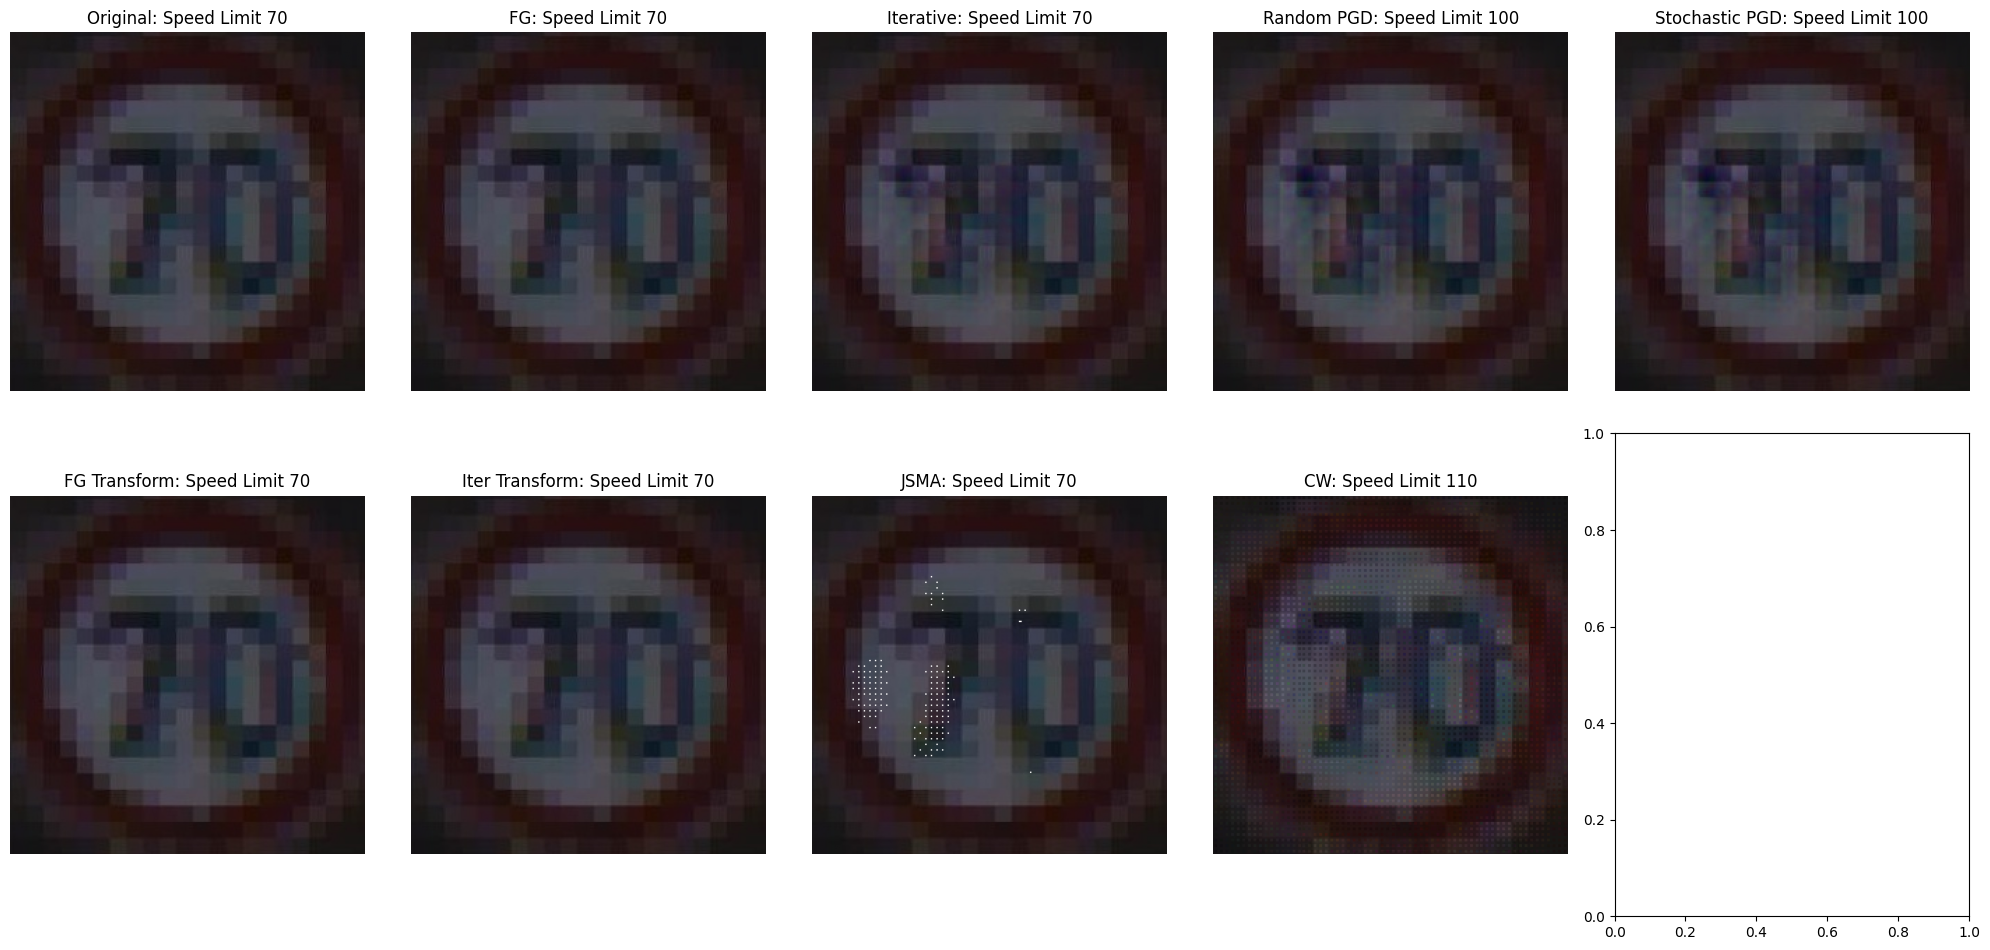

In [69]:
images, info = load_images_from_folder(ANNOTATIONS_CSV_PATH, os.path.join('Dataset','train'), num_images=1)

# Print the shapes to verify they can be different
for i, img in enumerate(images):
    print(f"Image {i} shape: {img.shape}")

# Set target class
target_class = 10  # Speed Limit 110

# FG attack
print("\nPerforming FG attack...")
magnitudes = [0.3]  # Increased from 0.1
fg_examples = targeted_attack(
    model,
    images,
    target_class_idx=target_class,
    attack_function="fg",
    mag_list=magnitudes
)

# Iterative attack
print("\nPerforming Iterative attack...")
iterative_examples = targeted_attack(
    model,
    images,
    target_class_idx=target_class,
    attack_function="iterative",
    norm="2",
    n_step=50,       # Increased from 20
    step_size=0.1    # Increased from 0.05
)

# Random PGD attack
print("\nPerforming Random PGD attack...")
rnd_pgd_examples = targeted_attack(
    model,
    images,
    target_class_idx=target_class,
    attack_function="rnd_pgd",
    norm="2",
    n_step=75,       # Increased from 30
    step_size=0.1,   # Increased from 0.05
    init_rnd=0.2     # Increased from 0.1
)

# Stochastic PGD attack
print("\nPerforming Stochastic PGD attack...")
s_pgd_examples = targeted_attack(
    model,
    images,
    target_class_idx=target_class,
    attack_function="spgd",
    norm="2",
    n_step=75,       # Increased from 30
    step_size=0.1,   # Increased from 0.05
    beta=0.2         # Increased from 0.1
)

# FG Transform attack
print("\nPerforming FG Transform attack...")
magnitudes = [0.3]   # Increased from 0.1
fg_transform_examples = targeted_attack(
    model,
    images,
    target_class_idx=target_class,
    attack_function="fg_transform",
    mag_list=magnitudes,
    batch_size=8     # Increased from 5
)

# Iterative Transform attack
print("\nPerforming Iterative Transform attack...")
iter_transform_examples, losses = targeted_attack(
    model,
    images,
    target_class_idx=target_class,
    attack_function="iter_transform",
    norm="2",
    n_step=10,
    step_size=0.08,  # Increased from 0.03
    batch_size=8     # Increased from 5
)

# JSMA attack
print("\nPerforming JSMA attack...")
jsma_examples = targeted_attack(
    model,
    images,
    target_class_idx=target_class,
    attack_function="jsma",
    theta=1.0,       # Increased from 0.1
    gamma=0.4,       # Increased from 0.1
    max_iter=150     # Increased from 100
)

# CW attack
print("\nPerforming CW attack...")
cw_examples = targeted_attack(
    model,
    images,
    target_class_idx=target_class,
    attack_function="f_cw",
    c=0.1,
    kappa=0,
    lr=0.01,
    binary_search_steps=2,
    max_iter=100
)

# Save the adversarial examples
for i, finfo in enumerate(info):
    # Save original image
    original_img = Image.fromarray((images[i] * 255).astype(np.uint8))
    original_img.save(os.path.join('temp', f"original_{finfo['filename']}.png"))

    # Save FG attack example
    if isinstance(fg_examples[0], list):  # If using multiple magnitudes
        adv_img = Image.fromarray((fg_examples[0][i] * 255).astype(np.uint8))
    else:
        adv_img = Image.fromarray((fg_examples[i] * 255).astype(np.uint8))
    adv_img.save(os.path.join('temp', f"adv_fg_{finfo['filename']}.png"))

    # Save Iterative attack example
    adv_img = Image.fromarray((iterative_examples[i] * 255).astype(np.uint8))
    adv_img.save(os.path.join('temp', f"adv_iterative_{finfo['filename']}.png"))

    # Save Random PGD attack example
    adv_img = Image.fromarray((rnd_pgd_examples[i] * 255).astype(np.uint8))
    adv_img.save(os.path.join('temp', f"adv_rnd_pgd_{finfo['filename']}.png"))

    # Save Stochastic PGD attack example
    adv_img = Image.fromarray((s_pgd_examples[i] * 255).astype(np.uint8))
    adv_img.save(os.path.join('temp', f"adv_s_pgd_{finfo['filename']}.png"))

    # Save FG Transform attack example
    if isinstance(fg_transform_examples[0], list):  # If using multiple magnitudes
        adv_img = Image.fromarray((fg_transform_examples[0][i] * 255).astype(np.uint8))
    else:
        adv_img = Image.fromarray((fg_transform_examples[i] * 255).astype(np.uint8))
    adv_img.save(os.path.join('temp', f"adv_fg_transform_{finfo['filename']}.png"))

    # Save Iterative Transform attack example
    adv_img = Image.fromarray((iter_transform_examples[i] * 255).astype(np.uint8))
    adv_img.save(os.path.join('temp', f"adv_iter_transform_{finfo['filename']}.png"))

    # Save JSMA attack example
    adv_img = Image.fromarray((jsma_examples[i] * 255).astype(np.uint8))
    adv_img.save(os.path.join('temp', f"adv_jsma_{finfo['filename']}.png"))

    # Save CW attack example
    adv_img = Image.fromarray((cw_examples[i] * 255).astype(np.uint8))
    adv_img.save(os.path.join('temp', f"adv_cw_{finfo['filename']}.png"))

# Evaluate attack success
print("\nEvaluating attack success rates...")
success_metrics = {
    "Original": 0,
    "FG": 0,
    "Iterative": 0,
    "Random PGD": 0,
    "Stochastic PGD": 0,
    "FG Transform": 0,
    "Iterative Transform": 0,
    "JSMA": 0,
    "CW": 0
}

for i in range(len(images)):
    # Evaluate original image
    orig_pred, _ = predict(model, images[i])
    print(f"\nImage {i} - Original prediction: {class_names[orig_pred]}")
    if orig_pred == target_class:
        success_metrics["Original"] += 1

    # Evaluate FG attack
    if isinstance(fg_examples[0], list):
        fg_pred, _ = predict(model, fg_examples[0][i])
    else:
        fg_pred, _ = predict(model, fg_examples[i])
    print(f"Image {i} - FG attack prediction: {class_names[fg_pred]}")
    if fg_pred == target_class:
        success_metrics["FG"] += 1

    # Evaluate Iterative attack
    iter_pred, _ = predict(model, iterative_examples[i])
    print(f"Image {i} - Iterative attack prediction: {class_names[iter_pred]}")
    if iter_pred == target_class:
        success_metrics["Iterative"] += 1

    # Evaluate Random PGD attack
    rnd_pgd_pred, _ = predict(model, rnd_pgd_examples[i])
    print(f"Image {i} - Random PGD attack prediction: {class_names[rnd_pgd_pred]}")
    if rnd_pgd_pred == target_class:
        success_metrics["Random PGD"] += 1

    # Evaluate Stochastic PGD attack
    s_pgd_pred, _ = predict(model, s_pgd_examples[i])
    print(f"Image {i} - Stochastic PGD attack prediction: {class_names[s_pgd_pred]}")
    if s_pgd_pred == target_class:
        success_metrics["Stochastic PGD"] += 1

    # Evaluate FG Transform attack
    if isinstance(fg_transform_examples[0], list):
        fg_transform_pred, _ = predict(model, fg_transform_examples[0][i])
    else:
        fg_transform_pred, _ = predict(model, fg_transform_examples[i])
    print(f"Image {i} - FG Transform attack prediction: {class_names[fg_transform_pred]}")
    if fg_transform_pred == target_class:
        success_metrics["FG Transform"] += 1

    # Evaluate Iterative Transform attack
    iter_transform_pred, _ = predict(model, iter_transform_examples[i])
    print(f"Image {i} - Iterative Transform attack prediction: {class_names[iter_transform_pred]}")
    if iter_transform_pred == target_class:
        success_metrics["Iterative Transform"] += 1

    # Evaluate JSMA attack
    jsma_pred, _ = predict(model, jsma_examples[i])
    print(f"Image {i} - JSMA attack prediction: {class_names[jsma_pred]}")
    if jsma_pred == target_class:
        success_metrics["JSMA"] += 1

    # Evaluate CW attack
    cw_pred, _ = predict(model, cw_examples[i])
    print(f"Image {i} - CW attack prediction: {class_names[cw_pred]}")
    if cw_pred == target_class:
        success_metrics["CW"] += 1

# Calculate and display success rates
print("\nAttack Success Rates:")
for attack, successes in success_metrics.items():
    success_rate = successes / len(images) * 100
    print(f"{attack}: {successes}/{len(images)} = {success_rate:.2f}%")

# Visualize one example with all attacks
if len(images) > 0:
    fig, axs = plt.subplots(2, 5, figsize=(20, 10))
    axs = axs.flatten()

    # Original image
    axs[0].imshow(images[0])
    axs[0].set_title(f"Original: {class_names[predict_class_only(model, images[0])]}")
    axs[0].axis('off')

    # FG attack
    if isinstance(fg_examples[0], list):
        axs[1].imshow(fg_examples[0][0])
        axs[1].set_title(f"FG: {class_names[predict_class_only(model, fg_examples[0][0])]}")
    else:
        axs[1].imshow(fg_examples[0])
        axs[1].set_title(f"FG: {class_names[predict_class_only(model, fg_examples[0])]}")
    axs[1].axis('off')

    # Iterative attack
    axs[2].imshow(iterative_examples[0])
    axs[2].set_title(f"Iterative: {class_names[predict_class_only(model, iterative_examples[0])]}")
    axs[2].axis('off')

    # Random PGD attack
    axs[3].imshow(rnd_pgd_examples[0])
    axs[3].set_title(f"Random PGD: {class_names[predict_class_only(model, rnd_pgd_examples[0])]}")
    axs[3].axis('off')

    # Stochastic PGD attack
    axs[4].imshow(s_pgd_examples[0])
    axs[4].set_title(f"Stochastic PGD: {class_names[predict_class_only(model, s_pgd_examples[0])]}")
    axs[4].axis('off')

    # FG Transform attack
    if isinstance(fg_transform_examples[0], list):
        axs[5].imshow(fg_transform_examples[0][0])
        axs[5].set_title(f"FG Transform: {class_names[predict_class_only(model, fg_transform_examples[0][0])]}")
    else:
        axs[5].imshow(fg_transform_examples[0])
        axs[5].set_title(f"FG Transform: {class_names[predict_class_only(model, fg_transform_examples[0])]}")
    axs[5].axis('off')

    # Iterative Transform attack
    axs[6].imshow(iter_transform_examples[0])
    axs[6].set_title(f"Iter Transform: {class_names[predict_class_only(model, iter_transform_examples[0])]}")
    axs[6].axis('off')

    # JSMA attack
    axs[7].imshow(jsma_examples[0])
    axs[7].set_title(f"JSMA: {class_names[predict_class_only(model, jsma_examples[0])]}")
    axs[7].axis('off')

    # CW attack
    axs[8].imshow(cw_examples[0])
    axs[8].set_title(f"CW: {class_names[predict_class_only(model, cw_examples[0])]}")
    axs[8].axis('off')

    plt.tight_layout()
    plt.savefig('temp/attack_comparison.png')
    plt.show()

## **Create Adversarial Dataset for Our Model; using I-FGSM, Stochastic PGD, JSMA, CW (Targetted, Very Aggresive)**

In [29]:
DATASET_FOLDER = os.path.join('Dataset','train')
#NUM_IMAGES = 100
NUM_IMAGES = 5

# Working on 100 images takes about 20 minutes in T4 environment.
# * Note that Google Colab disconnects you with 30 minutes of doing nothing!

In [ ]:
images, info = load_images_from_folder(ANNOTATIONS_CSV_PATH, DATASET_FOLDER,
                                       num_images=NUM_IMAGES, min_size=100)

# info has {filename, ground_truth_label, w, h}

# Print the shapes to verify they can be different
for i, img in enumerate(images):
    print(f"Image {i} shape: {img.shape}")

# Set target class
target_class = 10  # Speed Limit 110

# FGSM attack
print("\nPerforming FGSM...")
fg_examples = targeted_attack(
    model,
    images,
    target_class_idx=target_class,
    attack_function="fg",
    mag_list=[2.0]
)
fg_examples = fg_examples[0]

# Iterative attack
print("\nPerforming Iterative attack...")
iterative_examples = targeted_attack(
    model,
    images,
    target_class_idx=target_class,
    attack_function="iterative",
    norm="2",
    n_step=100,
    step_size=0.2
)

# Stochastic PGD attack
print("\nPerforming Stochastic PGD attack...")
spgd_examples = targeted_attack(
    model,
    images,
    target_class_idx=target_class,
    attack_function="spgd",
    norm="2",
    n_step=75,
    step_size=0.2,
    beta=0.1
)

# JSMA attack
print("\nPerforming  JSMA attack...")
jsma_examples = targeted_attack(
    model,
    images,
    target_class_idx=target_class,
    theta=1.0,
    gamma=0.4,
    attack_function="jsma",
    max_iter=100
)

print("\nPerforming clustered JSMA attack...")
cjsma_examples = targeted_attack(
    model,
    images,
    target_class_idx=target_class,
    attack_function="jsma_clustered",
    theta=5.0, # Strong perturbation
    gamma=0.1, # Allow modifying up to gamma*100% of pixels
    cluster_size=10,
    pattern_type='square', # Pattern shape ('square', 'circle', 'cross', 'random')
    max_iter=100
)


# CW attack
print("\nPerforming CW attack...")
cw_examples = targeted_attack(
    model,
    images,
    target_class_idx=target_class,
    attack_function="f_cw",
    c=0.1,
    kappa=-1,
    lr=0.2,
    binary_search_steps=2,
    max_iter=100
)

fg_line = []
iter_line = []
spgd_line = []
cjsma_line = []
jsma_line = []
cw_line = []

for i, dict_info in enumerate(info):
    orig_filename = dict_info['filename']
    orig_filepath = dict_info['filepath']
    ground_truth_label = dict_info['ground_truth_label']
    w = dict_info['w']
    h = dict_info['h']

    adv_fg_filepath = os.path.join(ADV_SAMPLES_PATH, 'fg', f"adv_fg_{orig_filename}.png")
    adv_iter_filepath = os.path.join(ADV_SAMPLES_PATH, 'iterative', f"adv_iterative_{orig_filename}.png")
    adv_spgd_filepath = os.path.join(ADV_SAMPLES_PATH,'spgd', f"adv_spgd_{orig_filename}.png")
    adv_cjsma_filepath = os.path.join(ADV_SAMPLES_PATH, 'cjsma', f"adv_cjsma_{orig_filename}.png")
    adv_jsma_filepath = os.path.join(ADV_SAMPLES_PATH, 'jsma', f"adv_jsma_{orig_filename}.png")
    adv_cw_filepath = os.path.join(ADV_SAMPLES_PATH, 'cw', f"adv_cw_{orig_filename}.png")

    fg_line.append(f'{orig_filepath},{adv_fg_filepath},fg,{class_to_idx[ground_truth_label]},{target_class},')
    iter_line.append(f'{orig_filepath},{adv_iter_filepath},iterative,{class_to_idx[ground_truth_label]},{target_class},')
    spgd_line.append(f'{orig_filepath},{adv_spgd_filepath},spgd,{class_to_idx[ground_truth_label]},{target_class},')
    cjsma_line.append(f'{orig_filepath},{adv_cjsma_filepath},jsma,{class_to_idx[ground_truth_label]},{target_class},')
    jsma_line.append(f'{orig_filepath},{adv_jsma_filepath},jsma,{class_to_idx[ground_truth_label]},{target_class},')
    cw_line.append(f'{orig_filepath},{adv_cw_filepath},cw,{class_to_idx[ground_truth_label]},{target_class},')


    # Save FGSM attack example
    adv_img = Image.fromarray((fg_examples[i] * 255).astype(np.uint8))
    adv_img.save(adv_fg_filepath)

    # Save I-FGSM attack example
    adv_img = Image.fromarray((iterative_examples[i] * 255).astype(np.uint8))
    adv_img.save(adv_iter_filepath)

    # Save SPGD attack example
    adv_img = Image.fromarray((spgd_examples[i] * 255).astype(np.uint8))
    adv_img.save(adv_spgd_filepath)

    # Save Clustered JSMA attack example
    adv_img = Image.fromarray((cjsma_examples[i] * 255).astype(np.uint8))
    adv_img.save(adv_cjsma_filepath)

    # Save JSMA attack example
    adv_img = Image.fromarray((jsma_examples[i] * 255).astype(np.uint8))
    adv_img.save(adv_jsma_filepath)

    # Save CW attack example
    adv_img = Image.fromarray((cw_examples[i] * 255).astype(np.uint8))
    adv_img.save(adv_cw_filepath)


print("\nEvaluating attack success rates...")
success_metrics = {
    "FG": 0,
    "Iterative": 0,
    "Stochastic PGD": 0,
    "Clustered JSMA": 0,
    "JSMA": 0,
    "CW": 0
}


with open(ANNOTATIONS_CSV_PATH, "a") as file:
    for i in range(len(images)):
        # Original Prediction
        orig_pred, orig_prob = infer(model, cv2.imread(info[i]['filepath']))

        # Evaluate FGSM attack
        adv_fg_pred, adv_fg_prob = predict(model, fg_examples[i])
        print(f"Image {i} - FGSM attack prediction: {class_names[adv_fg_pred]}")
        if adv_fg_pred == target_class:
            success_metrics["FG"] += 1

        # Evaluate I-FGSM attack
        adv_iter_pred, adv_iter_prob = predict(model, iterative_examples[i])
        print(f"Image {i} - Iterative attack prediction: {class_names[adv_iter_pred]}")
        if adv_iter_pred == target_class:
            success_metrics["Iterative"] += 1

        # Evaluate Stochastic PGD attack
        adv_spgd_pred, adv_spgd_prob = predict(model, spgd_examples[i])
        print(f"Image {i} - Stochastic PGD attack prediction: {class_names[adv_spgd_pred]}")
        if adv_spgd_pred == target_class:
            success_metrics["Stochastic PGD"] += 1

        # Evaluate Clustered JSMA attack
        adv_cjsma_pred, adv_cjsma_prob = predict(model, cjsma_examples[i])
        print(f"Image {i} - Clustered JSMA attack prediction: {class_names[adv_cjsma_pred]}")
        if adv_cjsma_pred == target_class:
            success_metrics["Clustered JSMA"] += 1

        # Evaluate JSMA attack
        adv_jsma_pred, adv_jsma_prob = predict(model, jsma_examples[i])
        print(f"Image {i} - JSMA attack prediction: {class_names[adv_jsma_pred]}")
        if adv_jsma_pred == target_class:
            success_metrics["JSMA"] += 1

        # Evaluate CW attack
        adv_cw_pred, adv_cw_prob = predict(model, cw_examples[i])
        print(f"Image {i} - CW attack prediction: {class_names[adv_cw_pred]}")
        if adv_cw_pred == target_class:
            success_metrics["CW"] += 1

        fg_line[i]   = fg_line[i]   + f'{orig_pred},{orig_prob[orig_pred].item()},{adv_fg_pred},{adv_fg_prob[adv_fg_pred].item()},{adv_fg_prob[orig_pred].item()}\n'
        iter_line[i] = iter_line[i] + f'{orig_pred},{orig_prob[orig_pred].item()},{adv_iter_pred},{adv_iter_prob[adv_iter_pred].item()},{adv_iter_prob[orig_pred].item()}\n'
        spgd_line[i] = spgd_line[i] + f'{orig_pred},{orig_prob[orig_pred].item()},{adv_spgd_pred},{adv_spgd_prob[adv_spgd_pred].item()},{adv_spgd_prob[orig_pred].item()}\n'
        cjsma_line[i] = cjsma_line[i] + f'{orig_pred},{orig_prob[orig_pred].item()},{adv_cjsma_pred},{adv_cjsma_prob[adv_cjsma_pred].item()},{adv_cjsma_prob[orig_pred].item()}\n'
        jsma_line[i] = jsma_line[i] + f'{orig_pred},{orig_prob[orig_pred].item()},{adv_jsma_pred},{adv_jsma_prob[adv_jsma_pred].item()},{adv_jsma_prob[orig_pred].item()}\n'
        cw_line[i] = cw_line[i] + f'{orig_pred},{orig_prob[orig_pred].item()},{adv_cw_pred},{adv_cw_prob[adv_cw_pred].item()},{adv_cw_prob[orig_pred].item()}\n'

        file.write(fg_line[i])
        file.write(iter_line[i])
        file.write(spgd_line[i])
        file.write(cjsma_line[i])
        file.write(jsma_line[i])
        file.write(cw_line[i])

# Calculate and display success rates
print("\nAttack Success Rates:")
for attack, successes in success_metrics.items():
    success_rate = successes / len(images) * 100
    print(f"{attack}: {successes}/{len(images)} = {success_rate:.2f}%")


!zip -r adv_samples.zip adv_samples/

Image 0 shape: (103, 151, 3)
Image 1 shape: (263, 264, 3)
Image 2 shape: (339, 330, 3)
Image 3 shape: (253, 254, 3)
Image 4 shape: (308, 314, 3)

Performing FGSM...

Performing Iterative attack...


In [ ]:
!mv adv_samples.zip /content/drive/MyDrive/ECE-653/

In [ ]:
from google.colab import runtime
runtime.unassign()

## **Evaluate Attack**

In [ ]:
for attack_type in ['iterative', 'spgd', 'jsma', 'cjsma' 'cw']:
    for i, dict_info in enumerate(info):
        filename = dict_info['filename']
        target_class = class_to_idx[dict_info['ground_truth_label']]

        adv_path = os.path.join('temp', attack_type, f"adv_{attack_type}_{filename}.png")
        orig_path = os.path.join('Dataset', 'train', filename)
        orig_img = cv2.imread(orig_path)
        adv_img = cv2.imread(adv_path)
        predicted_class_orig, prob_orig = perform_inference(model, orig_img, should_crop=False, display_pred=False)
        predicted_class_adv, prob_adv = perform_inference(model, adv_img, should_crop=False, display_pred=False)

        transform = get_transform()
        visualize_attack(True, transform(Image.open(orig_path)), transform(Image.open(adv_path)), target_class, predicted_class_orig, predicted_class_adv)
        print(f'Target: {class_names[target_class]}')
        print(f'   original pred : {class_names[predicted_class_orig]}', ',' , f'conf: {prob_orig[predicted_class_orig]*100} %')
        print(f'adversarial pred : {class_names[predicted_class_adv]}', ',' , f'conf: {prob_adv[predicted_class_adv]*100} %')
        print('-----------------------------------------------------')
